**Problem Statement:**

X Education sells online courses to industry professionals. 

The company markets its courses on several websites, search engines for users to land on their websites and browse for courses. 

If the user fills up a form with the contact details, the company uses the same to convert the users into paying customers of the company. 

The set of leads the company uses for a possible paying customer of the company, the conversion rate is pretty low. 

Hence the company would like us to build a Machine Learning Model which can automatically label possible customers (based on the leads provided) and increase the conversion rate for the company to approximately 80%


**Goals of the Case Study**

1. Build a logistic regression model to assign a lead score between 0 and 100 to each lead that the company can use to target potential leads. A higher score would mean that the lead is hot, i.e., most likely to convert, whereas a lower score would mean that the lead is cold and will mostly not get converted.

2. There are some more problems presented by the company that your model should be able to adjust to if the company's requirement changes in the future, so you will need to handle these. These problems are provided in a separate doc file. Please fill it based on the logistic regression model you got in the first step. Also, make sure you include this in your final PPT where you'll make recommendations.

In [89]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm
import sklearn

import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics

from sklearn.metrics import precision_recall_curve

In [90]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [91]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [92]:
#Read the Lead data set.

ds_leads = pd.read_csv('Leads.csv')
ds_leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


**Observation**

In the dataset there seems to be columns with 'Select'. It may be that the customer have not selected any value for the fields.
Therefore its best to change the Select to Nulls at this point. 

If any column value can be derived for any other column we will do it at the time of Univariate Analysis of the column.

In [93]:
#Print the dataset info ()
ds_leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [94]:
#Find the shape of the Lead dataset
print('Shape of the Leads dataset: ', ds_leads.shape)

Shape of the Leads dataset:  (9240, 37)


In [95]:
ds_leads.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [96]:
#Replace dataset columns having select with 'Null' 
ds_leads = ds_leads.replace('Select', np.nan)
ds_leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,NaN,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,NaN,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,NaN,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,NaN,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,NaN,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,NaN,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [97]:
#Find the Null % in the dataset
round((ds_leads.isnull().sum()/ds_leads.shape[0]),2)*100

Prospect ID                                       0.0
Lead Number                                       0.0
Lead Origin                                       0.0
Lead Source                                       0.0
Do Not Email                                      0.0
Do Not Call                                       0.0
Converted                                         0.0
TotalVisits                                       1.0
Total Time Spent on Website                       0.0
Page Views Per Visit                              1.0
Last Activity                                     1.0
Country                                          27.0
Specialization                                   37.0
How did you hear about X Education               78.0
What is your current occupation                  29.0
What matters most to you in choosing a course    29.0
Search                                            0.0
Magazine                                          0.0
Newspaper Article           

**Observation** - About Null Values

* 'How did you hear about X Education' - 78% Null Values 
* 'Lead Profile' - 74% Null values
* 'Lead Quality' - 52% Null Values
* 'Asymetrique Activity Index' - 46% Null Values
* 'Asymmetrique Profile Index' - 46% Null Values
* 'Asymmetrique Activity Score' - 46% Null Values
* 'Asymmetrique Profile Score'  - 46% Null Values
* 'City' - 40% Null Values
* 'Specialization' -37% Null Values
* 'Tags' - 36% Null Values
* 'What is your current occupation' -29% Null Values
* 'What matters most to you in choosing a course' - 29% Null Values
* 'Country' - 27% Null Values

* 'Total Visits' / 'Page Views Per Visit' / Last Activity' - 1% Null Values

## Data Cleaning

In [98]:
def print_data_distribution(ds,col):
    print(col,' - Column Unique Values')
    print('----------------------------------------------------------')
    print(round(ds[col].value_counts()/ds.shape[0],2)*100,'\n\n')
    
def drop_col(ds,col):
    ds.drop(columns=[col],inplace=True)
    print('Shape of the dataset after dropping {0} - {1}'.format(col,ds.shape))

In [99]:
# 'How did you hear about X Education' column contains 78% null values hence will drop the column

print_data_distribution(ds_leads,'How did you hear about X Education')
drop_col(ds_leads,'How did you hear about X Education')

How did you hear about X Education  - Column Unique Values
----------------------------------------------------------
Online Search            9.0
Word Of Mouth            4.0
Student of SomeSchool    3.0
Other                    2.0
Multiple Sources         2.0
Advertisements           1.0
Social Media             1.0
Email                    0.0
SMS                      0.0
Name: How did you hear about X Education, dtype: float64 


Shape of the dataset after dropping How did you hear about X Education - (9240, 36)


In [100]:
# 'Lead Profile' column contains 74% null values hence will check.There dont seem to have any other column from where we can derive the column value therfore will drop

print_data_distribution(ds_leads,'Lead Profile')
drop_col(ds_leads,'Lead Profile')

Lead Profile  - Column Unique Values
----------------------------------------------------------
Potential Lead                 17.0
Other Leads                     5.0
Student of SomeSchool           3.0
Lateral Student                 0.0
Dual Specialization Student     0.0
Name: Lead Profile, dtype: float64 


Shape of the dataset after dropping Lead Profile - (9240, 35)


In [101]:
# 'Lead Quality' column contains 52% null values therefore will check. There dont seem to have any other column from where we can derive the column value therfore will drop

print_data_distribution(ds_leads,'Lead Quality')
drop_col(ds_leads,'Lead Quality')

Lead Quality  - Column Unique Values
----------------------------------------------------------
Might be             17.0
Not Sure             12.0
High in Relevance     7.0
Worst                 7.0
Low in Relevance      6.0
Name: Lead Quality, dtype: float64 


Shape of the dataset after dropping Lead Quality - (9240, 34)


In [102]:
#'Asymmetrique Activity Index' / 'Asymmetrique Profile Index' / 'Asymmetrique Activity Score' / 'Asymmetrique Profile Score' columns contains 46% null values therefore will check.There dont seem to have any other column from where we can derive the column value therfore will drop

print_data_distribution(ds_leads,'Asymmetrique Activity Index')
drop_col(ds_leads,'Asymmetrique Activity Index')

print_data_distribution(ds_leads,'Asymmetrique Profile Index')
drop_col(ds_leads,'Asymmetrique Profile Index')
                        
print_data_distribution(ds_leads,'Asymmetrique Activity Score')
drop_col(ds_leads,'Asymmetrique Activity Score')

print_data_distribution(ds_leads,'Asymmetrique Profile Score')
drop_col(ds_leads,'Asymmetrique Profile Score')

Asymmetrique Activity Index  - Column Unique Values
----------------------------------------------------------
02.Medium    42.0
01.High       9.0
03.Low        4.0
Name: Asymmetrique Activity Index, dtype: float64 


Shape of the dataset after dropping Asymmetrique Activity Index - (9240, 33)
Asymmetrique Profile Index  - Column Unique Values
----------------------------------------------------------
02.Medium    30.0
01.High      24.0
03.Low        0.0
Name: Asymmetrique Profile Index, dtype: float64 


Shape of the dataset after dropping Asymmetrique Profile Index - (9240, 32)
Asymmetrique Activity Score  - Column Unique Values
----------------------------------------------------------
14.0    19.0
15.0    14.0
13.0     8.0
16.0     5.0
17.0     4.0
12.0     2.0
11.0     1.0
10.0     1.0
9.0      0.0
18.0     0.0
8.0      0.0
7.0      0.0
Name: Asymmetrique Activity Score, dtype: float64 


Shape of the dataset after dropping Asymmetrique Activity Score - (9240, 31)
Asymmetrique Pro

In [103]:
# 'Specialization' contains 37% null values therefore will check the distribution.

print_data_distribution(ds_leads,'Specialization')



Specialization  - Column Unique Values
----------------------------------------------------------
Finance Management                   11.0
Human Resource Management             9.0
Marketing Management                  9.0
Operations Management                 5.0
Business Administration               4.0
IT Projects Management                4.0
Supply Chain Management               4.0
Banking, Investment And Insurance     4.0
Media and Advertising                 2.0
Travel and Tourism                    2.0
International Business                2.0
Healthcare Management                 2.0
Hospitality Management                1.0
E-COMMERCE                            1.0
Retail Management                     1.0
Rural and Agribusiness                1.0
E-Business                            1.0
Services Excellence                   0.0
Name: Specialization, dtype: float64 




In [104]:
# 'Tags' contains 37% null values therefore will check the distribution.
print_data_distribution(ds_leads,'Tags')

Tags  - Column Unique Values
----------------------------------------------------------
Will revert after reading the email                  22.0
Ringing                                              13.0
Interested in other courses                           6.0
Already a student                                     5.0
Closed by Horizzon                                    4.0
switched off                                          3.0
Busy                                                  2.0
Lost to EINS                                          2.0
Not doing further education                           2.0
Interested  in full time MBA                          1.0
Graduation in progress                                1.0
invalid number                                        1.0
Diploma holder (Not Eligible)                         1.0
wrong number given                                    1.0
opp hangup                                            0.0
number not provided                       

In [105]:
# Tag can be derieved from the the Last Activity

print('Unique [Last Activity] for Null Tags \n {0}\n\n'.format(ds_leads.loc[ds_leads['Tags'].isnull()]['Last Activity'].unique()))


#ds_leads.loc[(ds_leads['Tags'].isnull()) & (ds_leads['Last Activity'] == 'Page Visited on Website'),'Tags'] = 'Still Thinking'
#ds_leads.loc[(ds_leads['Tags'].isnull()) & (ds_leads['Last Activity'] == 'Olark Chat Conversation'),'Tags'] = 'Still Thinking'
#ds_leads.loc[(ds_leads['Tags'].isnull()) & (ds_leads['Last Activity'] == 'Email Opened'),'Tags'] = 'Will revert after reading the email'
#ds_leads.loc[(ds_leads['Tags'].isnull()) & (ds_leads['Last Activity'] == 'Email Bounced'),'Tags'] = 'wrong number given'
#ds_leads.loc[(ds_leads['Tags'].isnull()) & (ds_leads['Last Activity'] == 'Email Link Clicked'),'Tags'] = 'Will revert after reading the email'
#ds_leads.loc[(ds_leads['Tags'].isnull()) & (ds_leads['Last Activity'] == 'Unreachable'),'Tags'] = 'wrong number given'
#ds_leads.loc[(ds_leads['Tags'].isnull()) & (ds_leads['Last Activity'] == 'Converted to Lead'),'Tags'] = 'Already a student'
#ds_leads.loc[(ds_leads['Tags'].isnull()) & (ds_leads['Last Activity'] == 'Unsubscribed'),'Tags'] = 'Not doing further education'
#ds_leads.loc[(ds_leads['Tags'].isnull()) & (ds_leads['Last Activity'] == 'Form Submitted on Website'),'Tags'] = 'Will revert after reading the email'
#ds_leads.loc[(ds_leads['Tags'].isnull()) & (ds_leads['Last Activity'] == 'View in browser link Clicked'),'Tags'] = 'Will revert after reading the email'
#ds_leads.loc[(ds_leads['Tags'].isnull()) & (ds_leads['Last Activity'] == 'SMS Sent'),'Tags'] = 'Still Thinking'    
#ds_leads.loc[(ds_leads['Tags'].isnull()) & (ds_leads['Last Activity'] == 'Had a Phone Conversation'),'Tags'] = 'Still Thinking'


Unique [Last Activity] for Null Tags 
 ['Olark Chat Conversation' 'Email Opened' 'Email Bounced'
 'Page Visited on Website' 'Email Link Clicked' nan 'Unreachable'
 'Converted to Lead' 'Unsubscribed' 'Form Submitted on Website'
 'View in browser link Clicked' 'SMS Sent' 'Had a Phone Conversation']




In [106]:
#Dropping Tags as it can be derieved from the the Last Activity, also it has 37%null values
drop_col(ds_leads,'Tags')

Shape of the dataset after dropping Tags - (9240, 29)


In [107]:
# 'What is your current occupation' contains 29% null values therefore will check the distribution.
print_data_distribution(ds_leads,'What is your current occupation')

What is your current occupation  - Column Unique Values
----------------------------------------------------------
Unemployed              61.0
Working Professional     8.0
Student                  2.0
Other                    0.0
Housewife                0.0
Businessman              0.0
Name: What is your current occupation, dtype: float64 




In [108]:
#Since the % of occupation under 'Housewife' / 'Businessman' / 'Other' is very less. Merging them togeter under 'Other' . Also replacing the Null with Others

ds_leads.loc[ds_leads['What is your current occupation'].isnull(),'What is your current occupation'] = 'Other'

print_data_distribution(ds_leads,'What is your current occupation')

What is your current occupation  - Column Unique Values
----------------------------------------------------------
Unemployed              61.0
Other                   29.0
Working Professional     8.0
Student                  2.0
Housewife                0.0
Businessman              0.0
Name: What is your current occupation, dtype: float64 




In [109]:
# 'What matters most to you in choosing a course' contains 29% null values therefore will check the distribution. There is not much variance therefore will drop the column

print_data_distribution(ds_leads,'What matters most to you in choosing a course')
drop_col(ds_leads,'What matters most to you in choosing a course')

What matters most to you in choosing a course  - Column Unique Values
----------------------------------------------------------
Better Career Prospects      71.0
Flexibility & Convenience     0.0
Other                         0.0
Name: What matters most to you in choosing a course, dtype: float64 


Shape of the dataset after dropping What matters most to you in choosing a course - (9240, 28)


In [110]:
# 'Country' contains 27% of Null value therefore will check. Will check if there of any more we can ppulate from City

print_data_distribution(ds_leads,'Country')

Country  - Column Unique Values
----------------------------------------------------------
India                   70.0
United States            1.0
United Arab Emirates     1.0
Singapore                0.0
Saudi Arabia             0.0
United Kingdom           0.0
Australia                0.0
Qatar                    0.0
Bahrain                  0.0
Hong Kong                0.0
France                   0.0
Oman                     0.0
unknown                  0.0
Nigeria                  0.0
Kuwait                   0.0
Canada                   0.0
Germany                  0.0
South Africa             0.0
Sweden                   0.0
Italy                    0.0
China                    0.0
Philippines              0.0
Uganda                   0.0
Asia/Pacific Region      0.0
Belgium                  0.0
Netherlands              0.0
Bangladesh               0.0
Ghana                    0.0
Switzerland              0.0
Indonesia                0.0
Kenya                    0.0
Liberia   

In [111]:
#Check the City and identify the Country

print('City (Before Country value Imputation)- City Values for Null Country \n{0}\n\n'.format(ds_leads[ds_leads.Country.isnull()].City.value_counts()))
ds_leads.loc[(ds_leads.City == 'Mumbai') | (ds_leads.City == 'Thane & Outskirts') | (ds_leads.City == 'Other Cities of Maharashtra'),['Country']]='India'
print('City (After Country value Imputation) - City Values for Null Country \n{0}\n\n'.format(ds_leads[ds_leads.Country.isnull()].City.value_counts()))

#Country after Imputation from City value
print_data_distribution(ds_leads,'Country')

City (Before Country value Imputation)- City Values for Null Country 
Mumbai                         211
Thane & Outskirts               80
Other Cities                    55
Other Cities of Maharashtra     43
Other Metro Cities              15
Tier II Cities                   2
Name: City, dtype: int64


City (After Country value Imputation) - City Values for Null Country 
Other Cities          55
Other Metro Cities    15
Tier II Cities         2
Name: City, dtype: int64


Country  - Column Unique Values
----------------------------------------------------------
India                   75.0
United Arab Emirates     0.0
United States            0.0
Singapore                0.0
Saudi Arabia             0.0
unknown                  0.0
Qatar                    0.0
United Kingdom           0.0
Nigeria                  0.0
South Africa             0.0
Australia                0.0
France                   0.0
Oman                     0.0
Bahrain                  0.0
Hong Kong               

In [112]:
#Since 23% of the country is Null and % of leads outside india is very less converting rest of the countries other than India into Other 'Country Category' 
ds_leads.loc[ds_leads.Country != 'India','Country'] = 'Other Country'

#Country after Imputation 
print_data_distribution(ds_leads,'Country')

Country  - Column Unique Values
----------------------------------------------------------
India            75.0
Other Country    25.0
Name: Country, dtype: float64 




In [113]:
#'City' contains 40% null values therefore will check the distribution. There dont seem to be much variance hence dropping 'City'

print_data_distribution(ds_leads,'City')
ds_leads.loc[ds_leads.City.isnull(),'City'] = 'Other Cities'

print_data_distribution(ds_leads,'City')

City  - Column Unique Values
----------------------------------------------------------
Mumbai                         35.0
Thane & Outskirts               8.0
Other Cities                    7.0
Other Cities of Maharashtra     5.0
Other Metro Cities              4.0
Tier II Cities                  1.0
Name: City, dtype: float64 


City  - Column Unique Values
----------------------------------------------------------
Other Cities                   47.0
Mumbai                         35.0
Thane & Outskirts               8.0
Other Cities of Maharashtra     5.0
Other Metro Cities              4.0
Tier II Cities                  1.0
Name: City, dtype: float64 




In [114]:
# 'TotalVisits' / 'Page Views Per Visit' have less than 1% Null value therefore will impute with the median of the columns

median_ViewsPerVisit = ds_leads.loc[:,'Page Views Per Visit'].median()
print ('median of [Page Views Per Visit] - ',median_ViewsPerVisit)
ds_leads.loc[ds_leads['Page Views Per Visit'].isnull(),'Page Views Per Visit'] = median_ViewsPerVisit


median_TotalVisits = ds_leads.loc[:,'TotalVisits'].median()
print ('median of [TotalVisits] - ',median_TotalVisits)
ds_leads.loc[ds_leads['TotalVisits'].isnull(),'TotalVisits'] = median_TotalVisits

print ('\n\nImputed both [TotalVisits] & [Page Views Per Visit] columns with the Median of the columns ')

median of [Page Views Per Visit] -  2.0
median of [TotalVisits] -  3.0


Imputed both [TotalVisits] & [Page Views Per Visit] columns with the Median of the columns 


In [115]:
#Last Activity contains 1% of Null Values therefore removing the rows having Null 
ds_leads = ds_leads[~ds_leads['Last Activity'].isnull()]

#Find the Null % in the dataset
round((ds_leads.isnull().sum()/ds_leads.shape[0]),2)*100

Prospect ID                                  0.0
Lead Number                                  0.0
Lead Origin                                  0.0
Lead Source                                  0.0
Do Not Email                                 0.0
Do Not Call                                  0.0
Converted                                    0.0
TotalVisits                                  0.0
Total Time Spent on Website                  0.0
Page Views Per Visit                         0.0
Last Activity                                0.0
Country                                      0.0
Specialization                              36.0
What is your current occupation              0.0
Search                                       0.0
Magazine                                     0.0
Newspaper Article                            0.0
X Education Forums                           0.0
Newspaper                                    0.0
Digital Advertisement                        0.0
Through Recommendati

**Observation**

The below columns were dropped because of higher % of Nulls or can be derieved from any other column information
*      a. 'How did you hear about X Education'
*      b. 'Lead Profile'
*      c. 'Asymmetrique Activity Index'
*      d. 'Asymmetrique Profile Index'
*      e. 'Asymmetrique Activity Score'
*      f. 'Asymmetrique Profile Score'
*      g. 'What matters most to you in choosing a course'



## Univariate/Bivariate Analysis

In [116]:
#Display the dataset column details 
ds_leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9137 entries, 0 to 9239
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Prospect ID                               9137 non-null   object 
 1   Lead Number                               9137 non-null   int64  
 2   Lead Origin                               9137 non-null   object 
 3   Lead Source                               9103 non-null   object 
 4   Do Not Email                              9137 non-null   object 
 5   Do Not Call                               9137 non-null   object 
 6   Converted                                 9137 non-null   int64  
 7   TotalVisits                               9137 non-null   float64
 8   Total Time Spent on Website               9137 non-null   int64  
 9   Page Views Per Visit                      9137 non-null   float64
 10  Last Activity                       

> **'Prospect ID'/ 'Lead Number'**

In [117]:
#Drop the Prospect ID, Lead Number which is a unique number for the leads

ds_leads.drop(columns=['Prospect ID','Lead Number'],inplace=True)
ds_leads.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization',
       'What is your current occupation', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'City', 'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [118]:
def plot_count(ds,col):
    fig, axs = plt.subplots(figsize=(14,7))
    sns.countplot(data=ds,x=col,hue='Converted',ax=axs)
    plt.xticks(rotation=90)
    plt.suptitle(col)
    print(col,' - % Distribution ')
    print('---------------------')
    print(round(ds[col].value_counts()/ds.shape[0],2)*100)
    def autolabel(rects):
      for rect in rects:
          height = rect.get_height()
          if height>0:
            axs.text(rect.get_x()+0.2, rect.get_height()/2+0.1,height,
                    ha='center', va='bottom', rotation=90, color='black',size=12,family='serif',style="normal",weight="light")

            
    autolabel(axs.patches)
    plt.show()

In [119]:
def pie_chart(ds,col):
    column = ds[col].value_counts(normalize=True)
    pie, ax = plt.subplots(figsize=[10,6])
    labels = column.keys()
    plt.pie(x=column, autopct="%.1f%%", labels=labels, pctdistance=0.5,explode=[0.05]*2)
    plt.title(col + " Distribution", fontsize=14);

> **Lead Source**

Lead Source  - % Distribution 
---------------------
Google               31.0
Direct Traffic       28.0
Olark Chat           19.0
Organic Search       13.0
Reference             5.0
Welingak Website      1.0
Referral Sites        1.0
Facebook              0.0
Other                 0.0
bing                  0.0
google                0.0
Click2call            0.0
Social Media          0.0
Live Chat             0.0
Press_Release         0.0
youtubechannel        0.0
Pay per Click Ads     0.0
welearnblog_Home      0.0
NC_EDM                0.0
testone               0.0
blog                  0.0
WeLearn               0.0
Name: Lead Source, dtype: float64


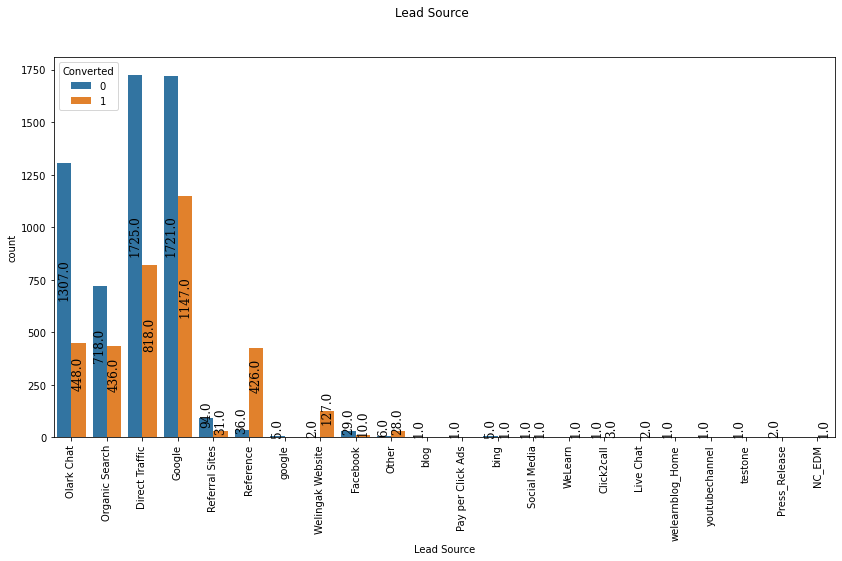

In [120]:
#There are few rows null in Lead Source which we will replace with 'Other'
ds_leads.loc[ds_leads['Lead Source'].isnull(),'Lead Source'] = 'Other'
plot_count(ds_leads,'Lead Source')

Since there is a lot of values for 'Lead Source' will club the category under 1% under Others

In [121]:
ds_leads.loc[ds_leads['Lead Source']=='google','Lead Source'] = 'Google'
ds_leads.loc[(ds_leads['Lead Source']!='Google') & 
             (ds_leads['Lead Source']!='Direct Traffic') & 
             (ds_leads['Lead Source']!='Olark Chat') & 
             (ds_leads['Lead Source']!='Organic Search') & 
             (ds_leads['Lead Source']!='Reference'),'Lead Source'] = 'Other'

Lead Source  - % Distribution 
---------------------
Google            31.0
Direct Traffic    28.0
Olark Chat        19.0
Organic Search    13.0
Reference          5.0
Other              4.0
Name: Lead Source, dtype: float64


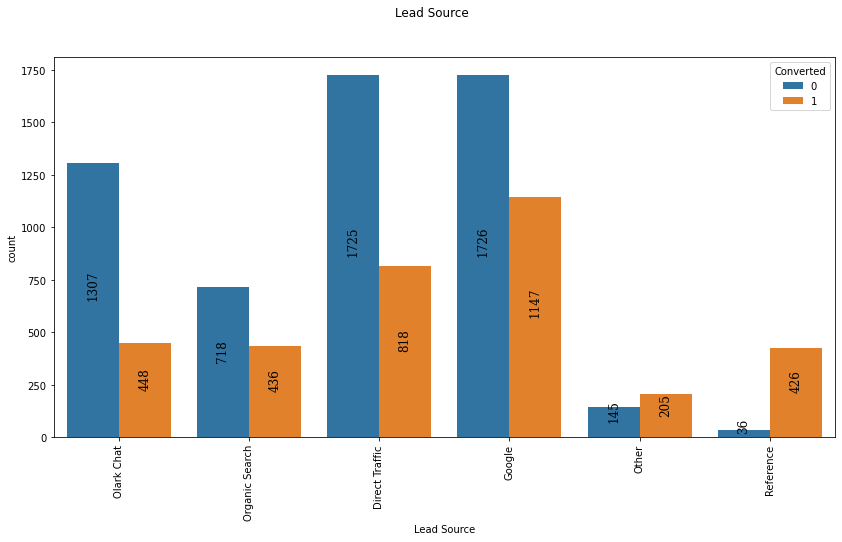

In [122]:
plot_count(ds_leads,'Lead Source')


> **Lead Origin**

Lead Origin  - % Distribution 
---------------------
Landing Page Submission    53.0
API                        39.0
Lead Add Form               7.0
Lead Import                 0.0
Quick Add Form              0.0
Name: Lead Origin, dtype: float64


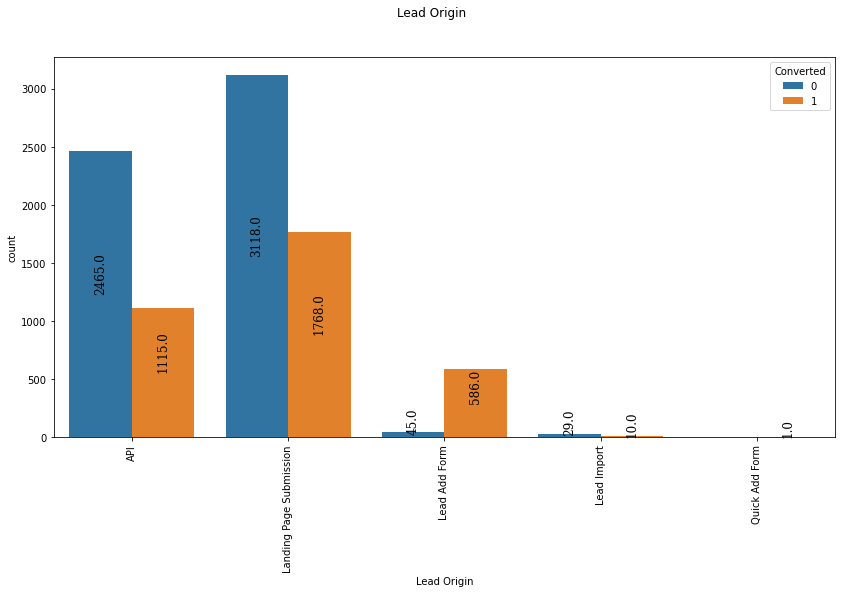

In [123]:
#ds_leads['Lead Origin'] = ds_leads['Lead Origin'].astype('category')
plot_count(ds_leads,'Lead Origin')

> **Do Not Email**

Do Not Email  - % Distribution 
---------------------
No     92.0
Yes     8.0
Name: Do Not Email, dtype: float64


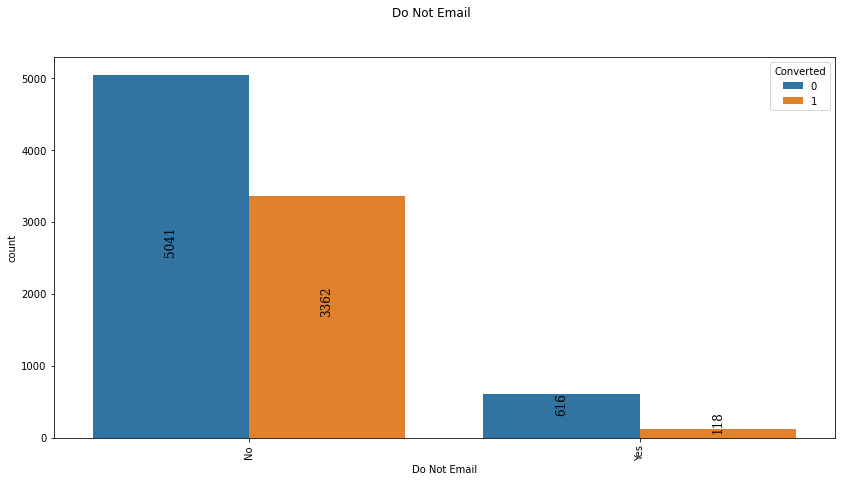

In [124]:
plot_count(ds_leads,'Do Not Email')

In [125]:
#Convert 'Yes' / 'No' to binary

ds_leads['Do Not Email'] = ds_leads['Do Not Email'].map({'Yes':1,'No':0})

> **Do Not Call** 

Do Not Call  - % Distribution 
---------------------
No     100.0
Yes      0.0
Name: Do Not Call, dtype: float64


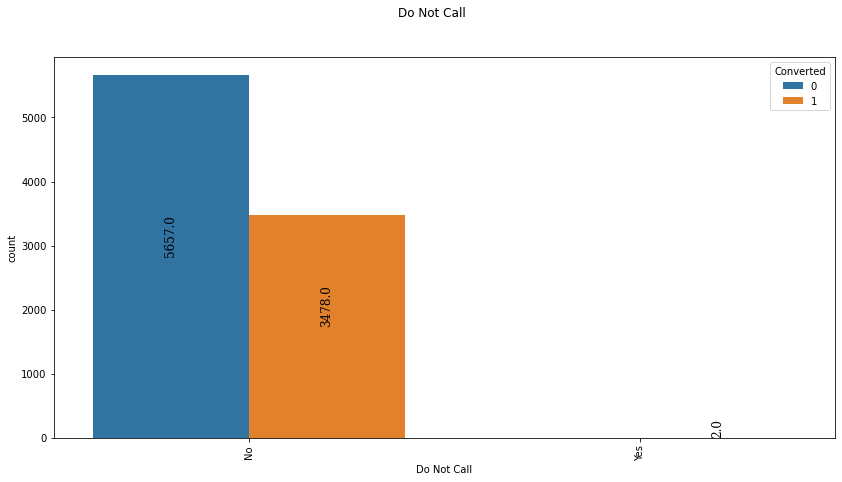

In [126]:
plot_count(ds_leads,'Do Not Call')

In [127]:
#There dont seem to be any variance therefore dropping the column 'Do Not Call'
drop_col(ds_leads,'Do Not Call')

Shape of the dataset after dropping Do Not Call - (9137, 25)


> **Converted**

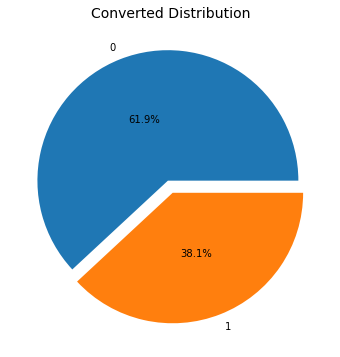

In [128]:
pie_chart(ds_leads,'Converted')

> **TotalVisits**

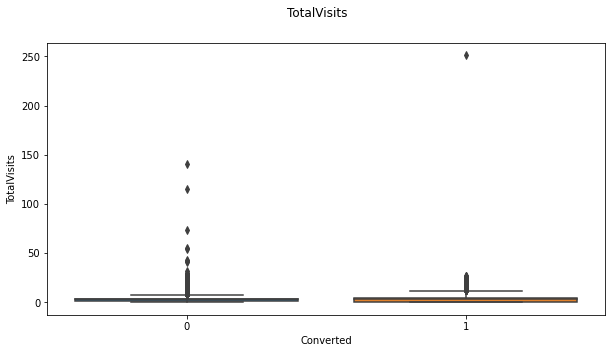

count    9137.000000
mean        3.443581
std         4.845886
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
95%        10.000000
99.5%      21.000000
max       251.000000
Name: TotalVisits, dtype: float64

In [129]:
# Plot the column to find outliers
plt.subplots(figsize=(10,5))
sns.boxplot(data=ds_leads,y='TotalVisits',x='Converted')
plt.suptitle('TotalVisits')
plt.show()

ds_leads['TotalVisits'].describe(percentiles=(0.25,0.5,0.75,0.95,0.995))

In [130]:
# Find the number of rows above - TotalVisits 99.5 percentile 

print('Number of rows above 99.5 % - {0}'.format(ds_leads[ds_leads['TotalVisits'] > 21].shape))

#41 rows can be dropped from the dataframe. 

Number of rows above 99.5 % - (41, 25)


In [131]:
#Drop the rows above 99.5 percentile - TotalVisits - 41 rows to be dropped

ds_leads = ds_leads[ds_leads.TotalVisits <= 21]
print('Shape of the dataframe now ',ds_leads.shape)

Shape of the dataframe now  (9096, 25)


In [132]:
ds_leads.TotalVisits.isnull().sum()

0

> **Total Time Spent on Website**

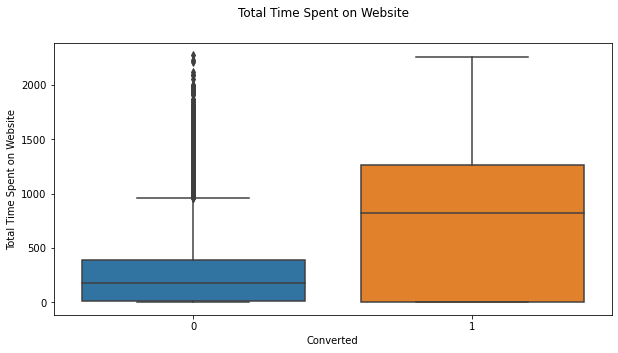

count    9096.000000
mean      482.168096
std       545.735110
min         0.000000
25%         9.000000
50%       245.000000
75%       921.000000
95%      1557.000000
99.5%    1932.525000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

In [133]:
# Plot the column to find outliers
plt.subplots(figsize=(10,5))
sns.boxplot(data=ds_leads,y='Total Time Spent on Website',x='Converted')
plt.suptitle('Total Time Spent on Website')
plt.show()

ds_leads['Total Time Spent on Website'].describe(percentiles=(0.25,0.5,0.75,0.95,0.995))

In [134]:
ds_leads['Total Time Spent on Website'].isnull().sum()

0

> **Page Views Per Visit**

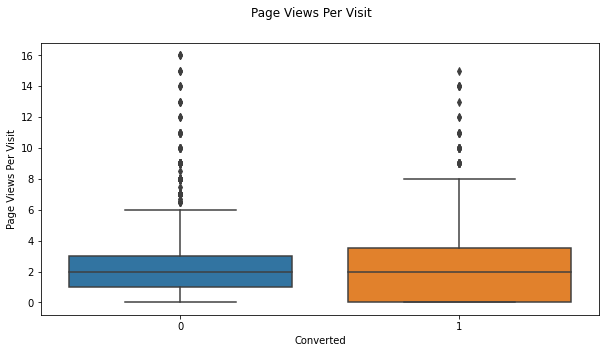

count    9096.000000
mean        2.342549
std         2.059286
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
95%         6.000000
99.5%      10.000000
max        16.000000
Name: Page Views Per Visit, dtype: float64

In [135]:
# Plot the column to find outliers
plt.subplots(figsize=(10,5))
sns.boxplot(data=ds_leads,y='Page Views Per Visit',x='Converted')
plt.suptitle('Page Views Per Visit')
plt.show()

ds_leads['Page Views Per Visit'].describe(percentiles=(0.25,0.5,0.75,0.95,0.995))

In [136]:
ds_leads['Page Views Per Visit'].isnull().sum()

0

> **Country**

Country  - % Distribution 
---------------------
India            76.0
Other Country    24.0
Name: Country, dtype: float64


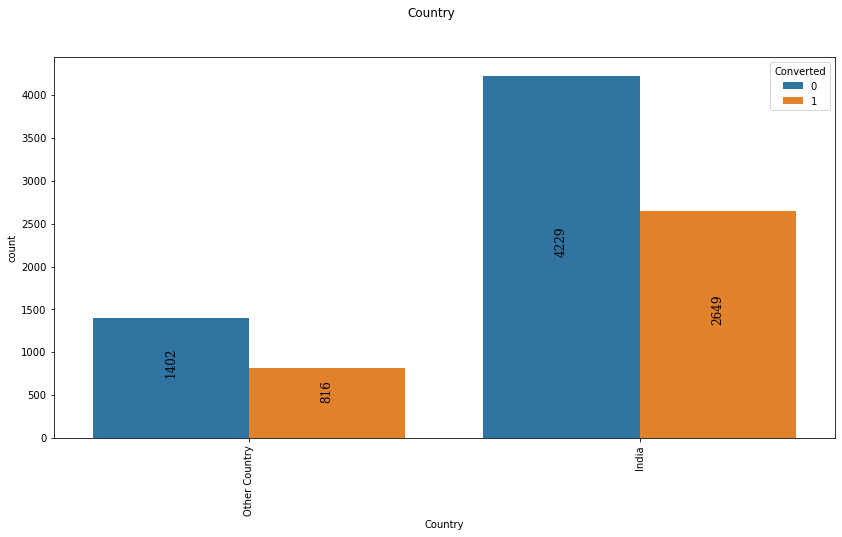

In [137]:
plot_count(ds_leads,'Country')

> **Specialization**

Specialization  - % Distribution 
---------------------
Not Sure                             36.0
Finance Management                   11.0
Human Resource Management             9.0
Marketing Management                  9.0
Operations Management                 5.0
Business Administration               4.0
IT Projects Management                4.0
Supply Chain Management               4.0
Banking, Investment And Insurance     4.0
Travel and Tourism                    2.0
Media and Advertising                 2.0
International Business                2.0
Healthcare Management                 2.0
E-COMMERCE                            1.0
Hospitality Management                1.0
Retail Management                     1.0
Rural and Agribusiness                1.0
E-Business                            1.0
Services Excellence                   0.0
Name: Specialization, dtype: float64


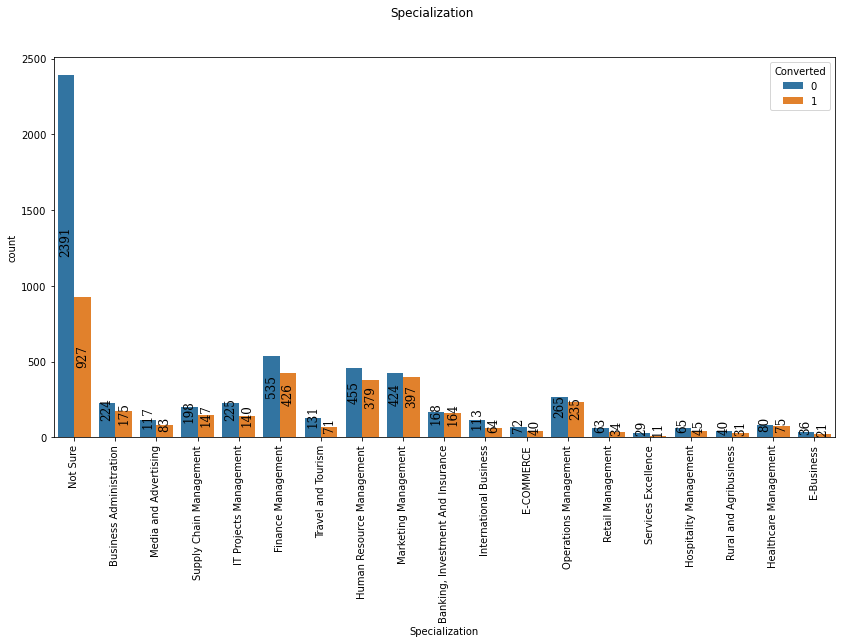

In [138]:
ds_leads.Specialization.fillna('Not Sure',inplace=True)
plot_count(ds_leads,'Specialization')

> **What is your current occupation**

What is your current occupation  - % Distribution 
---------------------
Unemployed              60.0
Other                   30.0
Working Professional     8.0
Student                  2.0
Housewife                0.0
Businessman              0.0
Name: What is your current occupation, dtype: float64


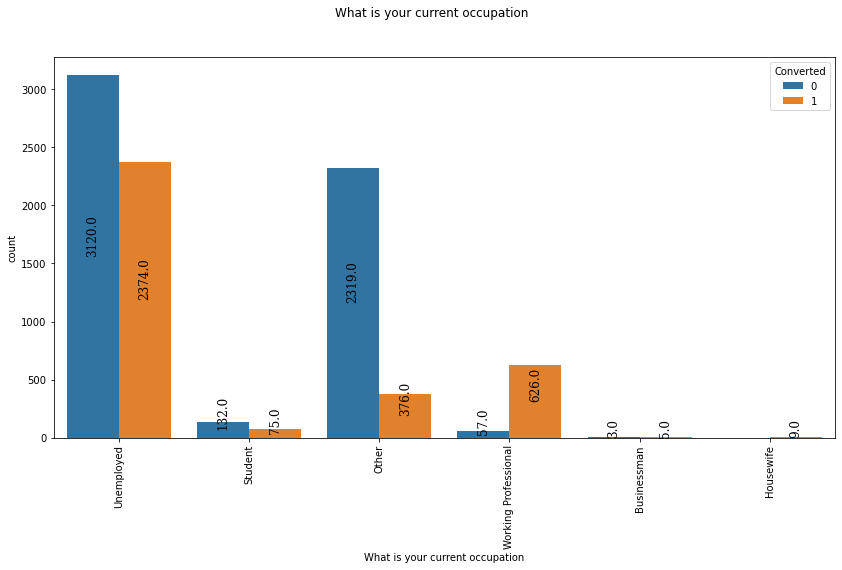

In [139]:
plot_count(ds_leads,'What is your current occupation')

What is your current occupation  - % Distribution 
---------------------
Unemployed              60.0
Other                   30.0
Working Professional     8.0
Student                  2.0
Name: What is your current occupation, dtype: float64


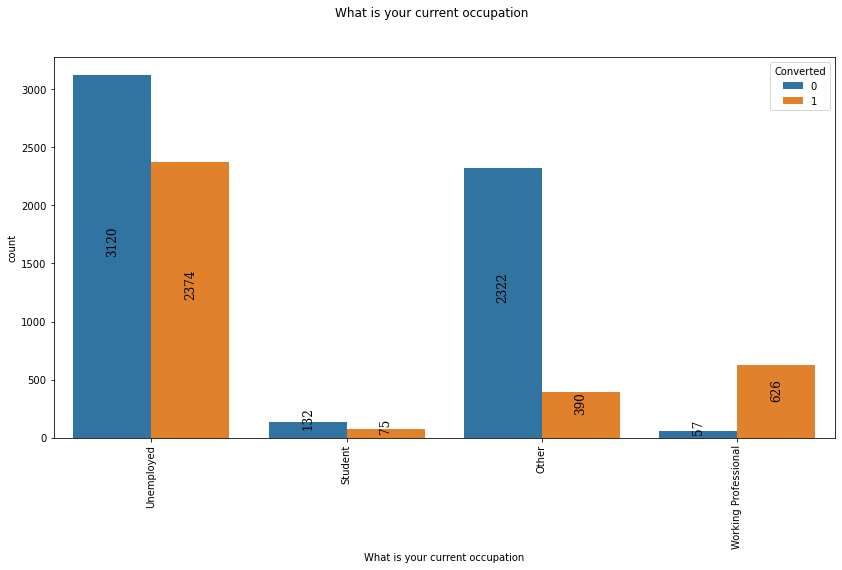

In [140]:
#Clubbing the Minority Groups into Other
ds_leads.loc[(ds_leads['What is your current occupation'] == 'Housewife') | 
            (ds_leads['What is your current occupation'] == 'Businessman'), 'What is your current occupation'
            ] = 'Other'
plot_count(ds_leads,'What is your current occupation')

> **Search** / **Magazine** / **Newspaper Article** / **X Education Forums** / **Newspaper** / **Digital Advertisement** / **Through Recommendations** / **Receive More Updates About Our Courses**

Search  - % Distribution 
---------------------
No     100.0
Yes      0.0
Name: Search, dtype: float64


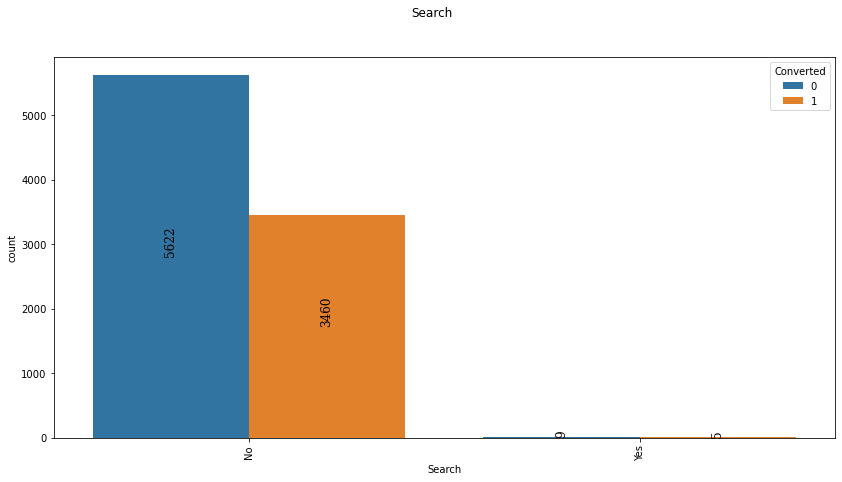

Magazine  - % Distribution 
---------------------
No    100.0
Name: Magazine, dtype: float64


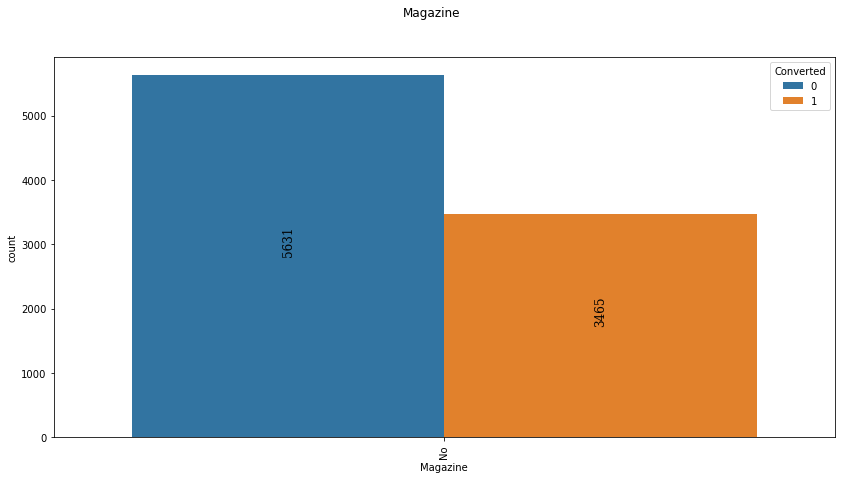

Newspaper Article  - % Distribution 
---------------------
No     100.0
Yes      0.0
Name: Newspaper Article, dtype: float64


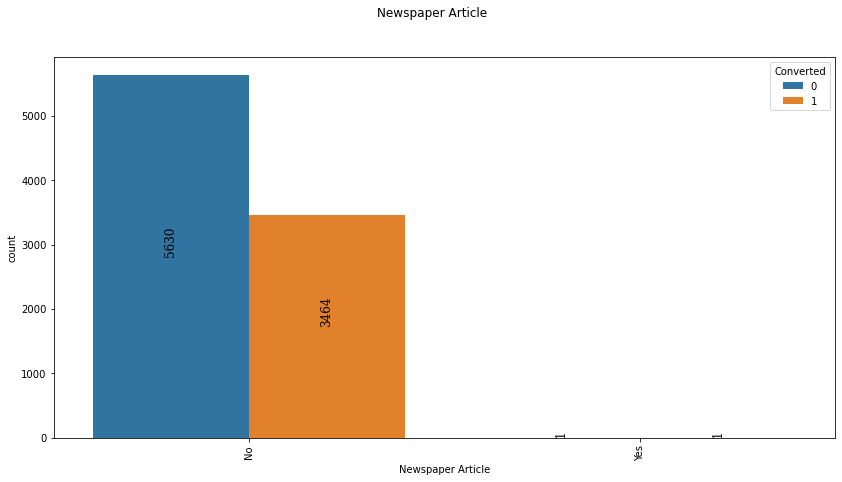

X Education Forums  - % Distribution 
---------------------
No     100.0
Yes      0.0
Name: X Education Forums, dtype: float64


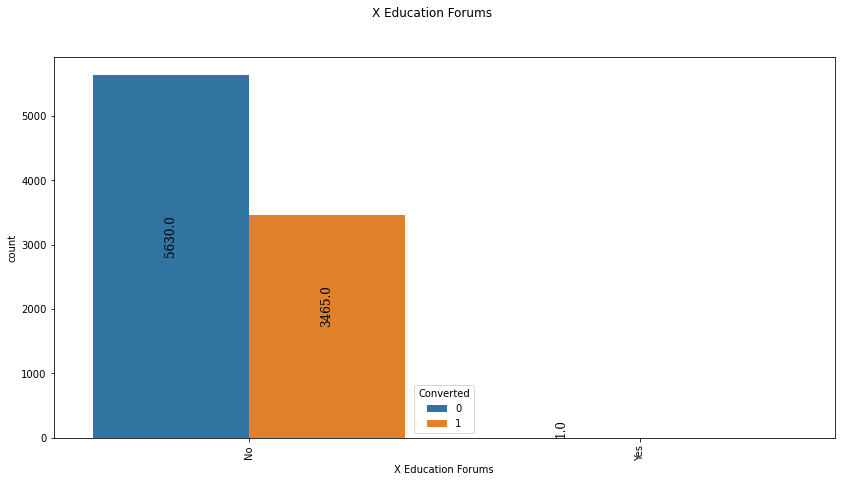

Newspaper  - % Distribution 
---------------------
No     100.0
Yes      0.0
Name: Newspaper, dtype: float64


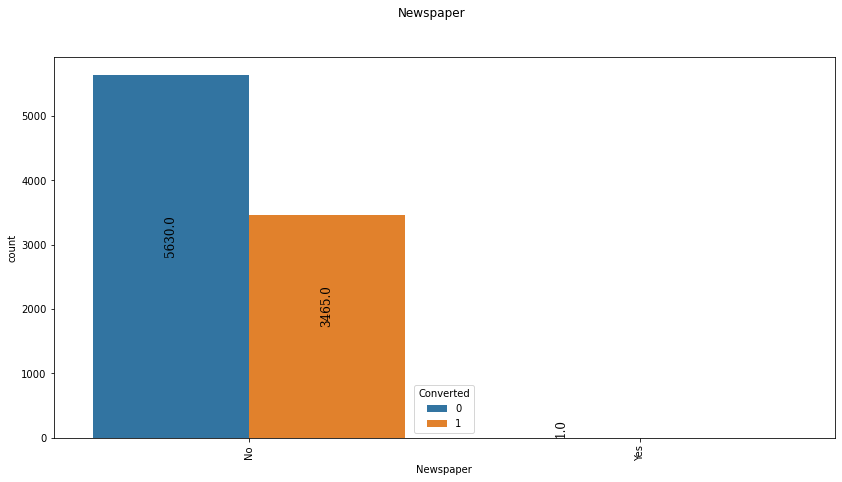

Digital Advertisement  - % Distribution 
---------------------
No     100.0
Yes      0.0
Name: Digital Advertisement, dtype: float64


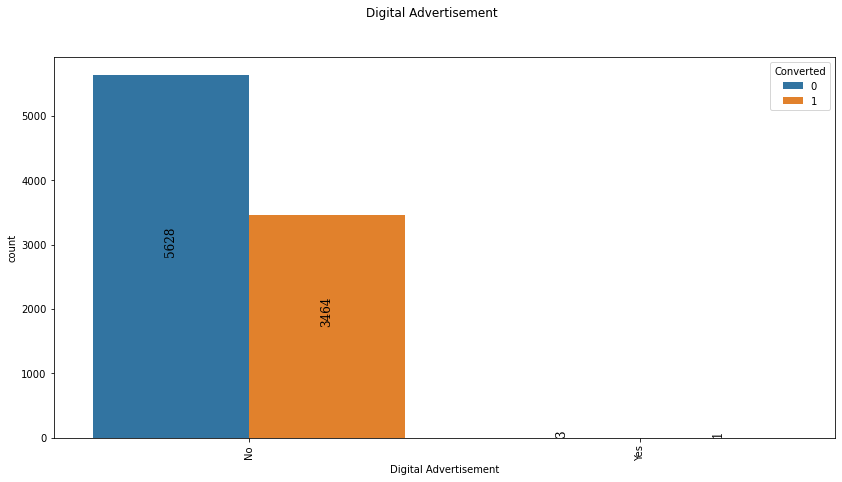

Through Recommendations  - % Distribution 
---------------------
No     100.0
Yes      0.0
Name: Through Recommendations, dtype: float64


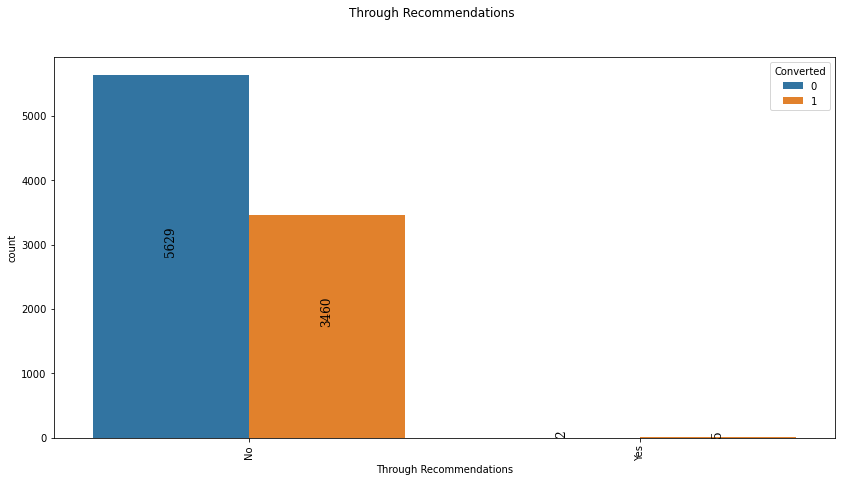

Receive More Updates About Our Courses  - % Distribution 
---------------------
No    100.0
Name: Receive More Updates About Our Courses, dtype: float64


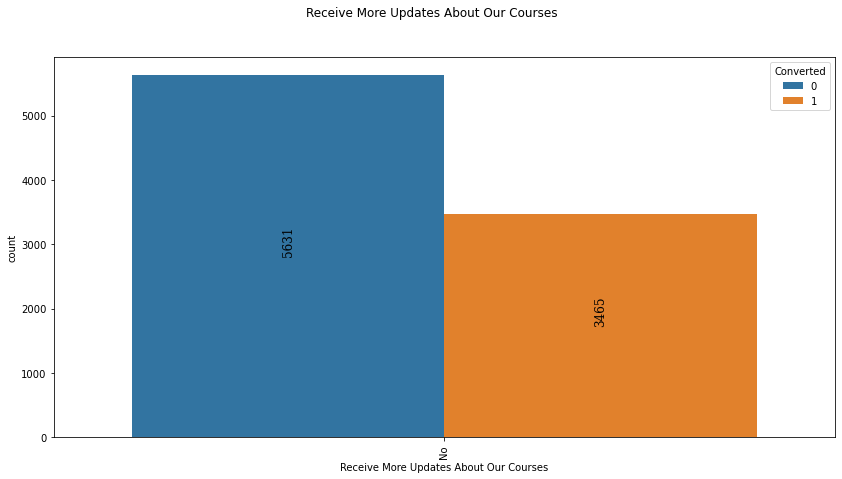

Update me on Supply Chain Content  - % Distribution 
---------------------
No    100.0
Name: Update me on Supply Chain Content, dtype: float64


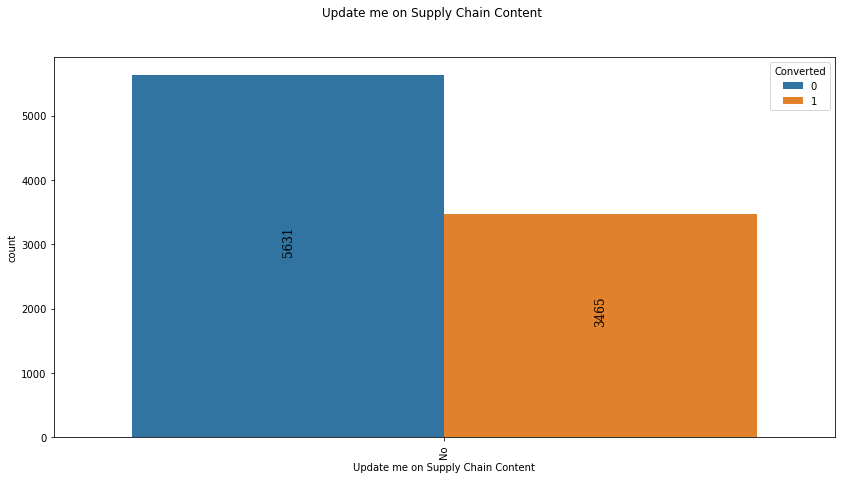

Get updates on DM Content  - % Distribution 
---------------------
No    100.0
Name: Get updates on DM Content, dtype: float64


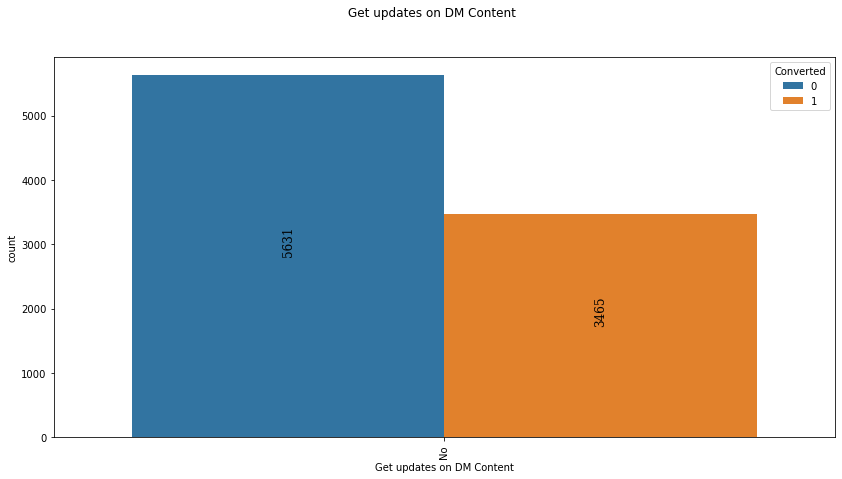

I agree to pay the amount through cheque  - % Distribution 
---------------------
No    100.0
Name: I agree to pay the amount through cheque, dtype: float64


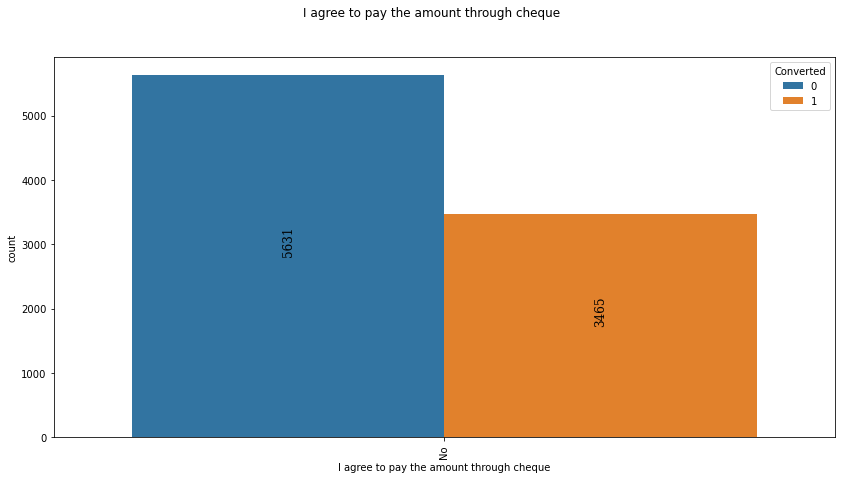

[None, None, None, None, None, None, None, None, None, None, None]

In [141]:
ls_cols = ['Search','Magazine','Newspaper Article','X Education Forums','Newspaper','Digital Advertisement',
           'Through Recommendations','Receive More Updates About Our Courses','Update me on Supply Chain Content',
           'Get updates on DM Content','I agree to pay the amount through cheque'
          ]

[plot_count(ds_leads,col) for col in ls_cols]

There is Zero Variance for the columns Search / Magazine / Newspaper Article / X Education Forums / Newspaper / Digital Advertisement / 'Through Recommendations','Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content','I agree to pay the amount through cheque'.
Therefore will drop the columns

In [142]:
ds_leads.drop(columns=['Search','Magazine','Newspaper Article','X Education Forums','Newspaper','Digital Advertisement','Through Recommendations','Receive More Updates About Our Courses','Update me on Supply Chain Content'
                       ,'Get updates on DM Content','I agree to pay the amount through cheque'
                      ],inplace=True)
ds_leads.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Converted',
       'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
       'Last Activity', 'Country', 'Specialization',
       'What is your current occupation', 'City',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

> **A free copy of Mastering The Interview**

A free copy of Mastering The Interview  - % Distribution 
---------------------
No     68.0
Yes    32.0
Name: A free copy of Mastering The Interview, dtype: float64


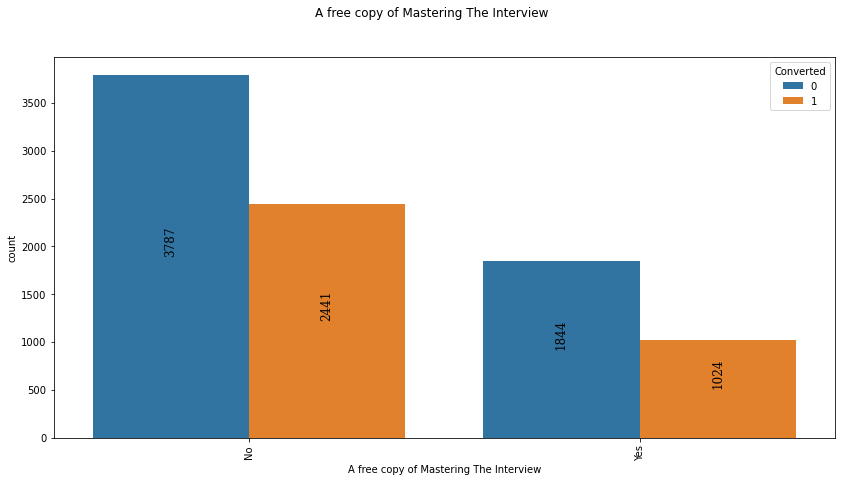

In [143]:
plot_count(ds_leads,'A free copy of Mastering The Interview')

> **City**

City  - % Distribution 
---------------------
Other Cities                   47.0
Mumbai                         35.0
Thane & Outskirts               8.0
Other Cities of Maharashtra     5.0
Other Metro Cities              4.0
Tier II Cities                  1.0
Name: City, dtype: float64


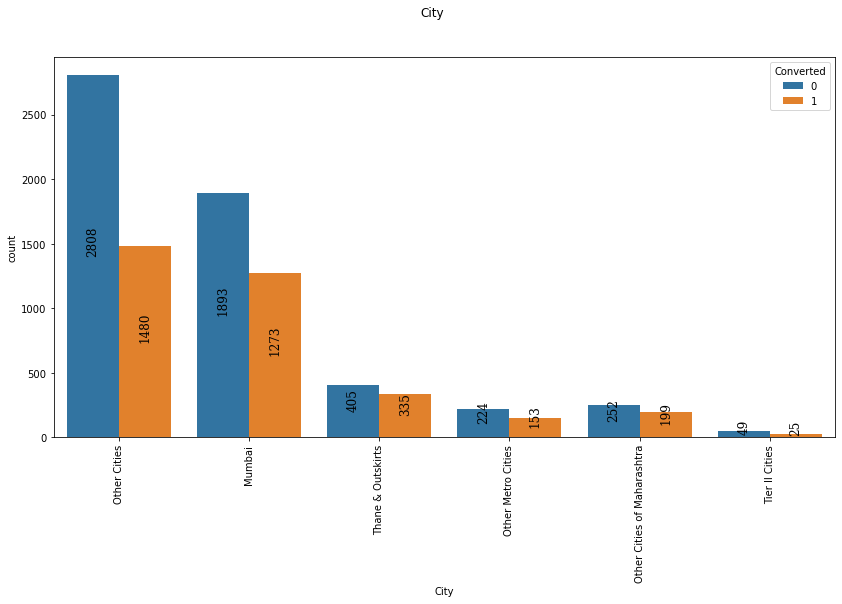

In [144]:
plot_count(ds_leads,'City')



**Last Notable Activity**

In [145]:
ds_leads['Last Notable Activity'].value_counts()

Modified                        3295
Email Opened                    2816
SMS Sent                        2168
Page Visited on Website          303
Olark Chat Conversation          182
Email Link Clicked               172
Email Bounced                     60
Unsubscribed                      47
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
Resubscribed to emails             1
Form Submitted on Website          1
View in browser link Clicked       1
Approached upfront                 1
Email Received                     1
Name: Last Notable Activity, dtype: int64

Last Notable Activity  - % Distribution 
---------------------
Modified                   36.0
Email Opened               31.0
SMS Sent                   24.0
Page Visited on Website     3.0
Olark Chat Conversation     2.0
Email Link Clicked          2.0
Email Bounced               1.0
Others                      1.0
Unsubscribed                1.0
Name: Last Notable Activity, dtype: float64


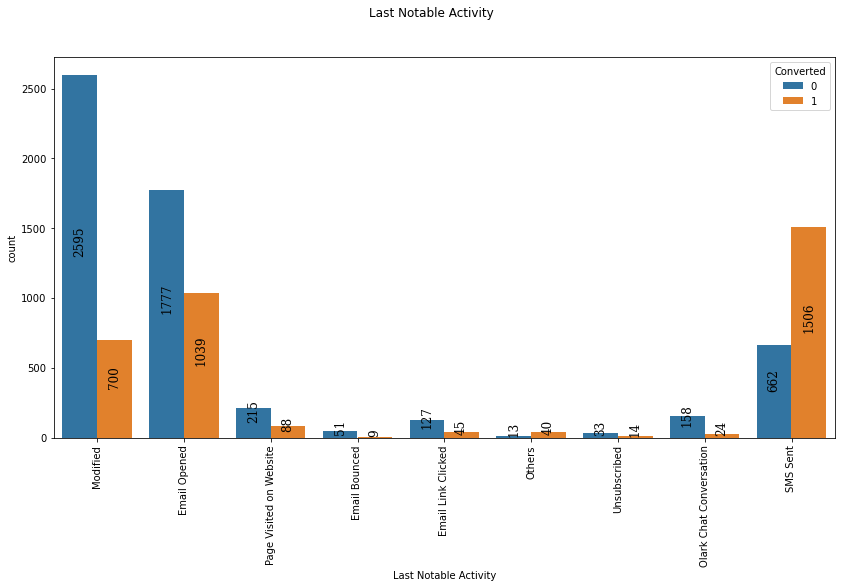

In [146]:
ds_leads['Last Notable Activity'] = ds_leads['Last Notable Activity'].replace(['Had a Phone Conversation','Unreachable','Email Marked Spam','Email Received','Resubscribed to emails','Approached upfront','Form Submitted on Website','View in browser link Clicked'],'Others')
plot_count(ds_leads,'Last Notable Activity')

**LastActivity**

In [147]:
ds_leads['Last Activity'] = ds_leads['Last Activity'].replace(['Had a Phone Conversation', 'View in browser link Clicked', 
                                                       'Visited Booth in Tradeshow', 'Approached upfront',
                                                       'Resubscribed to emails','Email Received', 'Email Marked Spam'], 'Others')


Last Activity  - % Distribution 
---------------------
Email Opened                 38.0
SMS Sent                     30.0
Olark Chat Conversation      11.0
Page Visited on Website       7.0
Converted to Lead             5.0
Email Bounced                 4.0
Email Link Clicked            3.0
Form Submitted on Website     1.0
Unreachable                   1.0
Unsubscribed                  1.0
Others                        1.0
Name: Last Activity, dtype: float64


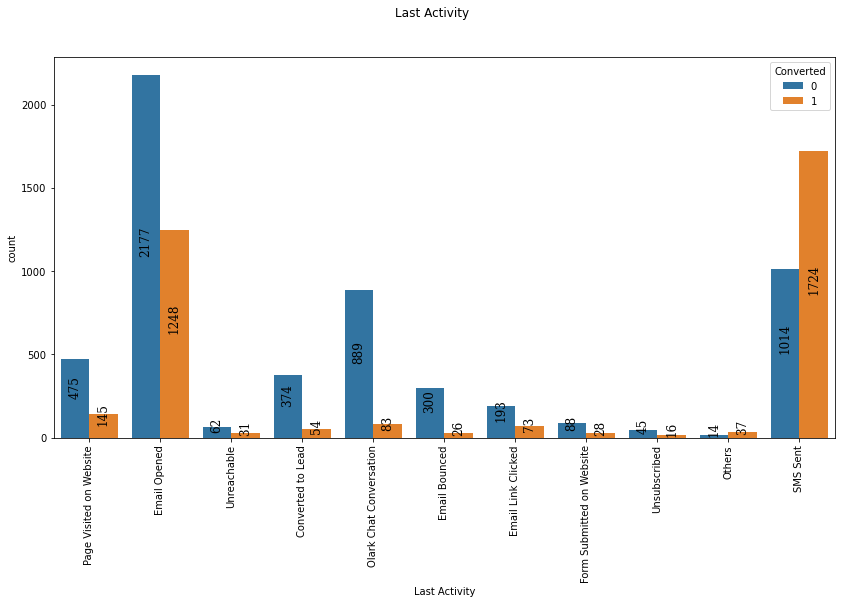

In [148]:
plot_count(ds_leads,'Last Activity')

In [149]:
#Display the dataset column details 
ds_leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9096 entries, 0 to 9239
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9096 non-null   object 
 1   Lead Source                             9096 non-null   object 
 2   Do Not Email                            9096 non-null   int64  
 3   Converted                               9096 non-null   int64  
 4   TotalVisits                             9096 non-null   float64
 5   Total Time Spent on Website             9096 non-null   int64  
 6   Page Views Per Visit                    9096 non-null   float64
 7   Last Activity                           9096 non-null   object 
 8   Country                                 9096 non-null   object 
 9   Specialization                          9096 non-null   object 
 10  What is your current occupation         9096 non-null   obje

Find if there is any Correlation between the columns identified

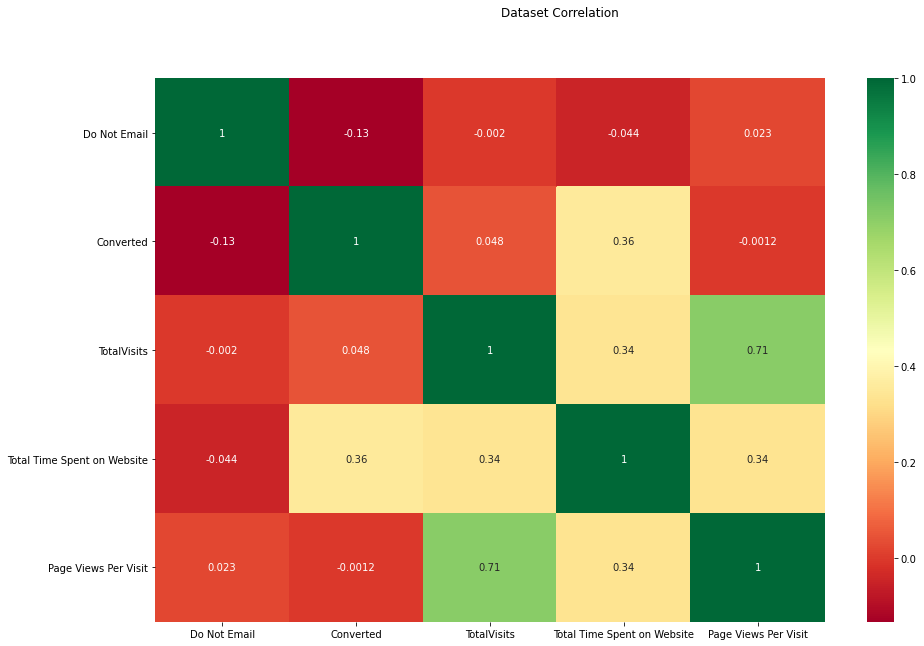

,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
Do Not Email,1.000000,-0.132821,-0.002026,-0.044427,0.023219
Converted,-0.132821,1.000000,0.047948,0.355665,-0.001188
TotalVisits,-0.002026,0.047948,1.000000,0.337799,0.709711
Total Time Spent on Website,-0.044427,0.355665,0.337799,1.000000,0.335170
Page Views Per Visit,0.023219,-0.001188,0.709711,0.335170,1.000000


In [150]:
plt.subplots(figsize=(15,10))
sns.heatmap(ds_leads.corr(),annot=True,cmap='RdYlGn')
plt.suptitle('Dataset Correlation')
plt.show()

ds_leads.corr()

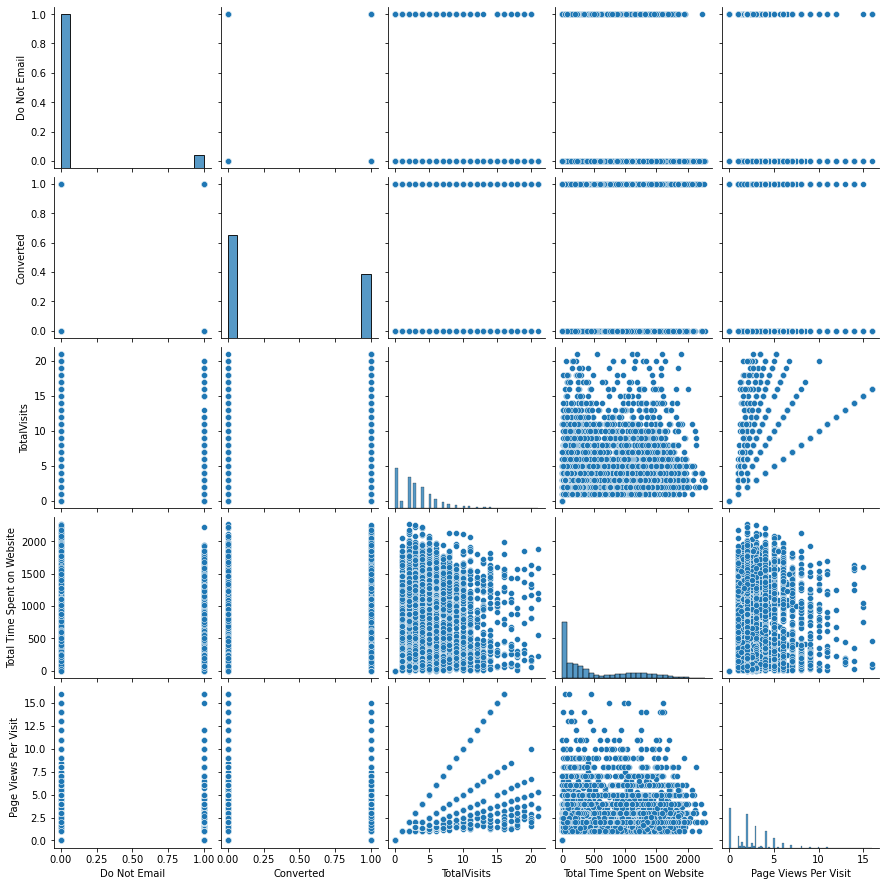

In [151]:
sns.pairplot(ds_leads)
plt.show()

Total Time Spent on Website - Total Visits

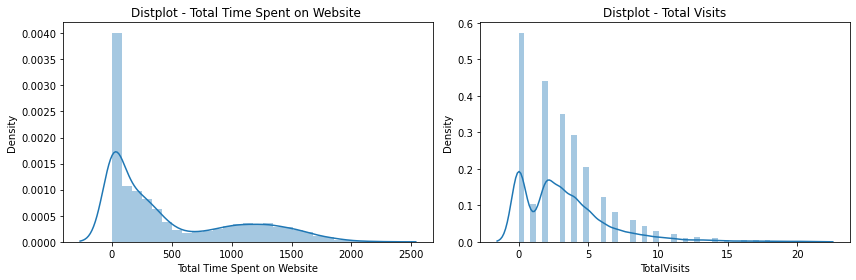

In [152]:
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    sns.distplot(ds_leads['Total Time Spent on Website'])
    plt.title("Distplot - Total Time Spent on Website ")

    plt.subplot(122)
    sns.distplot(ds_leads['TotalVisits'])
    plt.title("Distplot - Total Visits")
    
    plt.tight_layout()
    plt.show()

Page Views per visit - Total Visits

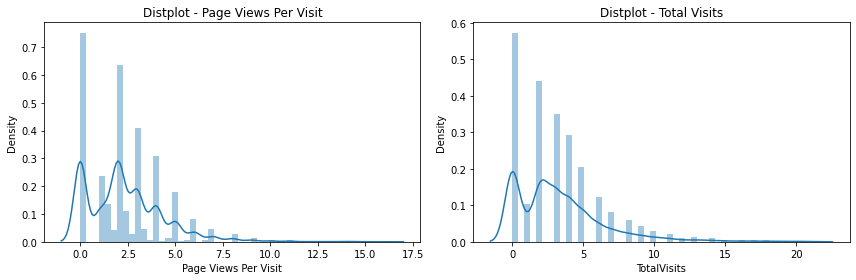

In [153]:
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    sns.distplot(ds_leads['Page Views Per Visit'])
    plt.title("Distplot - Page Views Per Visit")

    plt.subplot(122)
    sns.distplot(ds_leads['TotalVisits'])
    plt.title("Distplot - Total Visits")
    
    plt.tight_layout()
    plt.show()

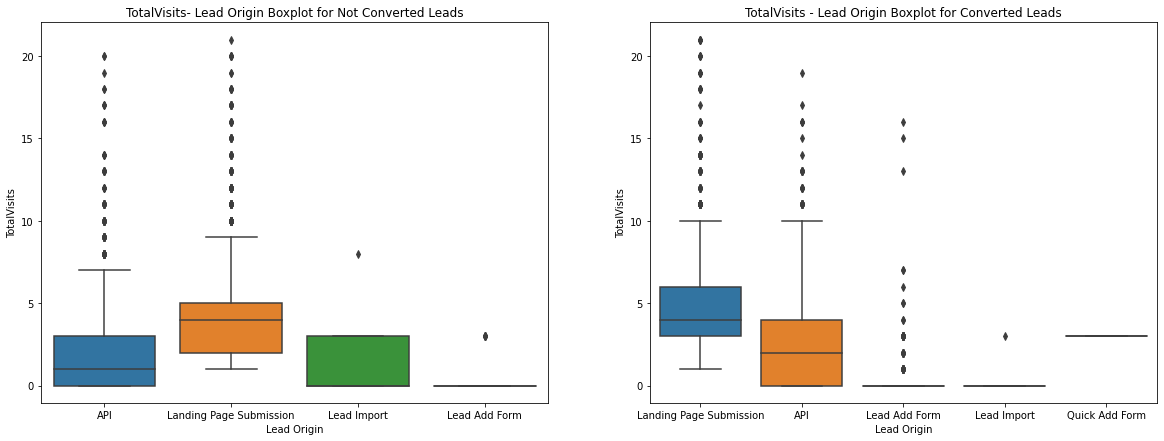

In [154]:

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
sns.boxplot(y='TotalVisits', data=ds_leads[ds_leads['Converted'] == 0], x="Lead Origin").set_title("TotalVisits- Lead Origin Boxplot for Not Converted Leads")
plt.subplot(1,2,2)
sns.boxplot(y='TotalVisits', data=ds_leads[ds_leads['Converted'] == 1], x="Lead Origin").set_title("TotalVisits - Lead Origin Boxplot for Converted Leads")
plt.show()

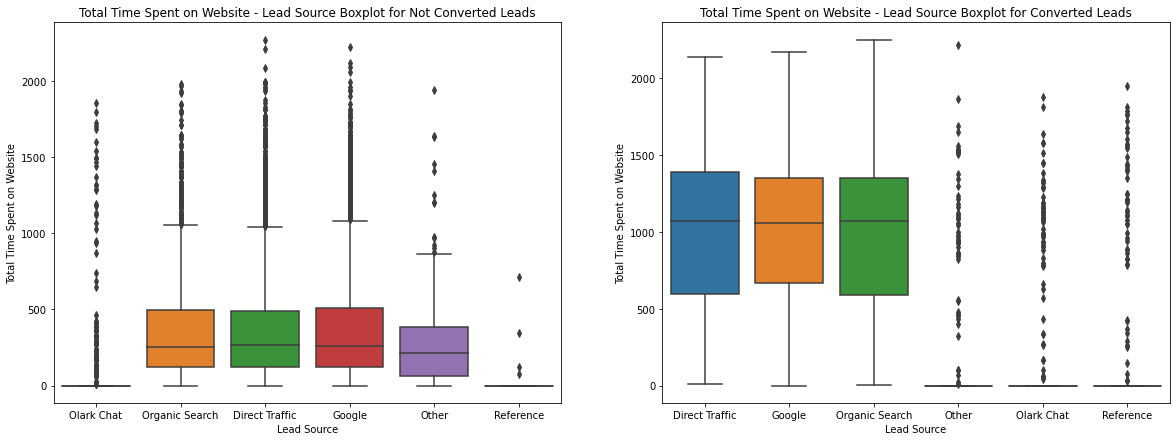

In [155]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
sns.boxplot(y='Total Time Spent on Website', data=ds_leads[ds_leads['Converted'] == 0], x="Lead Source").set_title("Total Time Spent on Website - Lead Source Boxplot for Not Converted Leads")
plt.subplot(1,2,2)
sns.boxplot(y='Total Time Spent on Website', data=ds_leads[ds_leads['Converted'] == 1], x="Lead Source").set_title("Total Time Spent on Website - Lead Source Boxplot for Converted Leads")
plt.show()

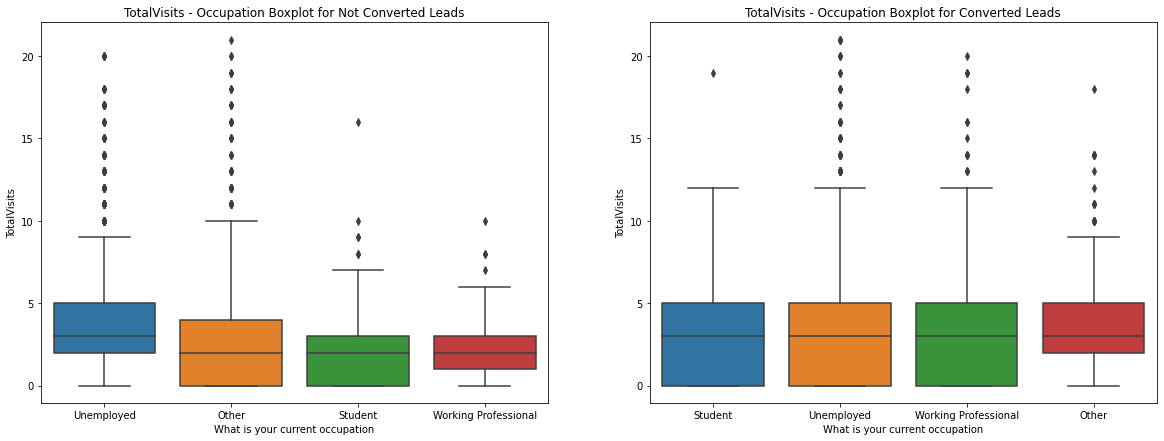

In [156]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
sns.boxplot(y='TotalVisits', data=ds_leads[ds_leads['Converted'] == 0], x="What is your current occupation").set_title("TotalVisits - Occupation Boxplot for Not Converted Leads")
plt.subplot(1,2,2)
sns.boxplot(y='TotalVisits', data=ds_leads[ds_leads['Converted'] == 1], x="What is your current occupation").set_title("TotalVisits - Occupation Boxplot for Converted Leads")
plt.show()

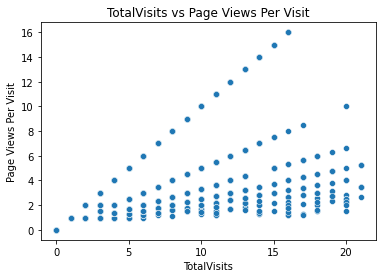

In [157]:
sns.scatterplot(x='TotalVisits',y='Page Views Per Visit',data=ds_leads)
plt.title('TotalVisits vs Page Views Per Visit')
plt.show()

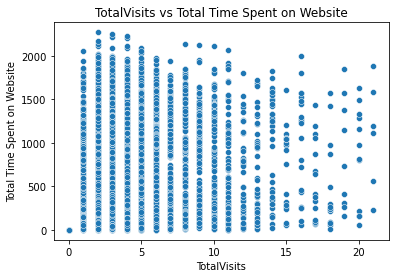

In [158]:
sns.scatterplot(x='TotalVisits',y='Total Time Spent on Website',data=ds_leads)
plt.title('TotalVisits vs Total Time Spent on Website')
plt.show()

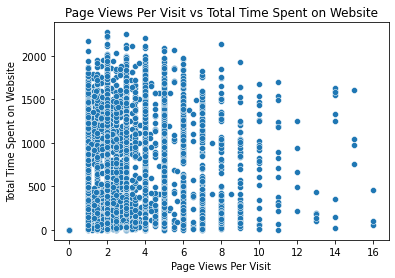

In [159]:
sns.scatterplot(x='Page Views Per Visit',y='Total Time Spent on Website',data=ds_leads)
plt.title('Page Views Per Visit vs Total Time Spent on Website')
plt.show()

# Prepare the data for the Model

#### Create Dummy Variable for the Model

In [160]:
col_dummy = ['Lead Origin',
             'Lead Source',
             'Country',
             'What is your current occupation',
             'City',
             'A free copy of Mastering The Interview',
             'Last Notable Activity',
             'Last Activity',
             'Specialization'
            ]

col_num =['Do Not Email',
          'Converted',
          'TotalVisits',
          'Total Time Spent on Website',
          'Page Views Per Visit',
         ]

In [161]:
ds_leads_m = ds_leads[col_num]

for col in col_dummy:
    ds_temp = pd.get_dummies(ds_leads[col],prefix=col,drop_first=True)
    ds_leads_m = pd.concat([ds_temp, ds_leads_m], axis = 1)

ds_leads_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9096 entries, 0 to 9239
Data columns (total 60 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Specialization_Business Administration                9096 non-null   uint8  
 1   Specialization_E-Business                             9096 non-null   uint8  
 2   Specialization_E-COMMERCE                             9096 non-null   uint8  
 3   Specialization_Finance Management                     9096 non-null   uint8  
 4   Specialization_Healthcare Management                  9096 non-null   uint8  
 5   Specialization_Hospitality Management                 9096 non-null   uint8  
 6   Specialization_Human Resource Management              9096 non-null   uint8  
 7   Specialization_IT Projects Management                 9096 non-null   uint8  
 8   Specialization_International Business                 9096

In [162]:
ds_leads_m.head()

,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Not Sure,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Others,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent,Last Notable Activity_Unsubscribed,A free copy of Mastering The Interview_Yes,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Country_Other Country,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other,Lead Source_Reference,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0.0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,5.0,674,2.5
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2.0,1532,2.0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,305,1.0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,2.0,1428,1.0


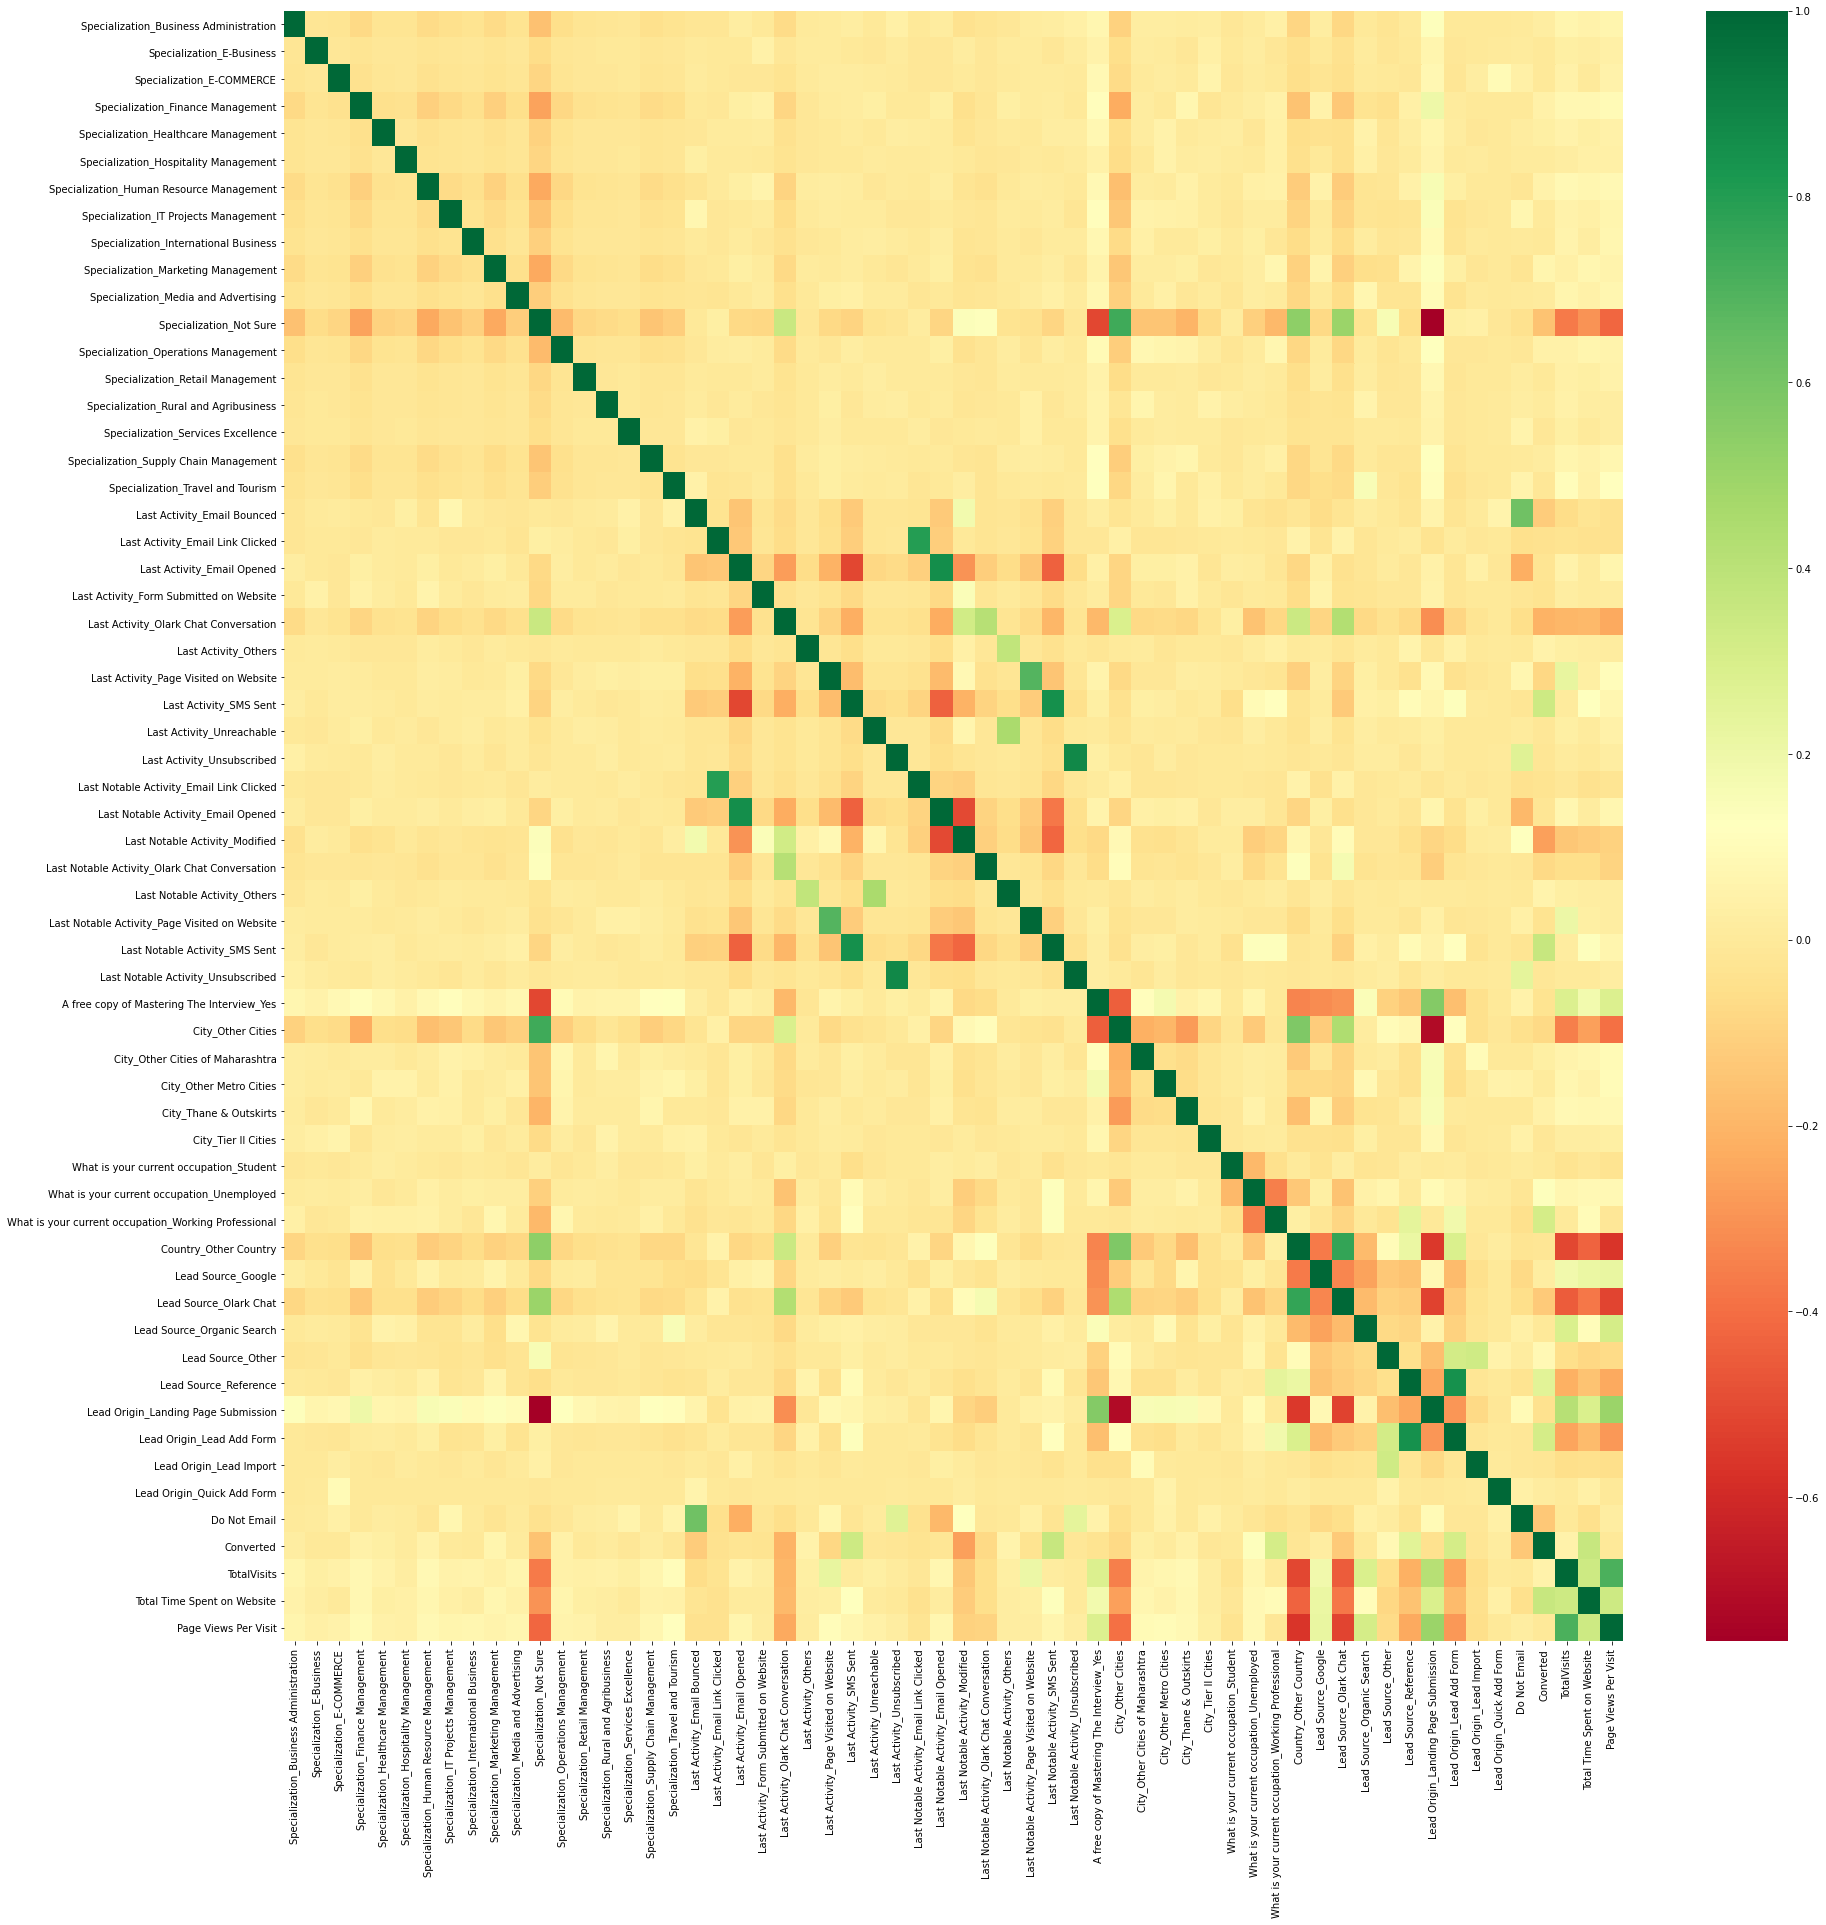

In [163]:
plt.subplots(figsize=(30,30))
sns.heatmap(ds_leads_m.corr(),cmap='RdYlGn')
plt.show()

## Split the data into Train and Test - Scale

In [164]:
np.random.seed(0)
df_train,df_test = train_test_split(ds_leads_m,train_size=0.7,test_size=0.3)

print('\n\nThe model dataframe was split into train {0} and test {1}'.format(df_train.shape,df_test.shape))



The model dataframe was split into train (6367, 60) and test (2729, 60)


**Scale the numeric columns**

In [165]:
scaler = MinMaxScaler()

df_train[col_num] = scaler.fit_transform(df_train[col_num])
df_train.head()

,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Not Sure,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Others,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent,Last Notable Activity_Unsubscribed,A free copy of Mastering The Interview_Yes,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Country_Other Country,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other,Lead Source_Reference,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
1077,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.095238,0.145246,0.12500
1576,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.285714,0.518486,0.18750
3473,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0.0,1.0,0.000000,0.000000,0.00000
8673,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.142857,0.370599,0.09375
12,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0.0,1.0,0.523810,0.676937,0.68750


In [166]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6367 entries, 1077 to 2790
Data columns (total 60 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Specialization_Business Administration                6367 non-null   uint8  
 1   Specialization_E-Business                             6367 non-null   uint8  
 2   Specialization_E-COMMERCE                             6367 non-null   uint8  
 3   Specialization_Finance Management                     6367 non-null   uint8  
 4   Specialization_Healthcare Management                  6367 non-null   uint8  
 5   Specialization_Hospitality Management                 6367 non-null   uint8  
 6   Specialization_Human Resource Management              6367 non-null   uint8  
 7   Specialization_IT Projects Management                 6367 non-null   uint8  
 8   Specialization_International Business                 6

## Build the Model - Train Dataset

In [167]:
y_train = df_train.pop('Converted')
X_train = df_train.copy()

In [168]:
lm=LinearRegression()
lm.fit(X_train,y_train)
    

def log_reg(modelname):
    rfe = RFE(lm,15)
    rfe = rfe.fit(X_train,y_train)
    list(zip(X_train.columns,rfe.support_,rfe.ranking_))
    col = X_train.columns[rfe.support_]
    X_train_rfe = X_train[col]
    X_train_lm_const = sm.add_constant(X_train_rfe)
    lr = sm.GLM(y_train, X_train_lm_const,family = sm.families.Binomial()).fit()
    print('\n\n  ***********************',modelname,"**********************\n\n")
    print(lr.summary())
    return X_train_lm_const,lr

def Check_VIF(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print('\n\n**********Variance Inflation Factor of the Model********** \n\n {0}\n\n'.format(vif))

def Generate_Model(col_to_drop,model_no):
    if len(col_to_drop) > 1:
        X_train.drop(columns=col_to_drop,inplace=True)
        print('Dropped column : ', col_to_drop)
    X_train_oc, log = log_reg('Model '+ str(model_no))
    Check_VIF(X_train_oc)
    return X_train_oc, log
    

In [169]:

X_train = df_train.copy()

model_col =['','Lead Source_Reference'
            
            ]

i=1

X_train_oc= pd.DataFrame()

for col in model_col:
    X_train_oc, log = Generate_Model(col,i)
    i+=1
    
print("*************************************************************************************************")
print("                               END OF MODELLING    ")
print("*************************************************************************************************")


print("Features and their Coefficient Values")
log.params.abs().sort_values(ascending=False)                                                                                          







  *********************** Model 1 **********************


                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6367
Model:                            GLM   Df Residuals:                     6351
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2561.3
Date:                Wed, 13 Oct 2021   Deviance:                       5122.5
Time:                        23:20:07   Pearson chi2:                 6.47e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

Total Time Spent on Website                             4.610469
Lead Origin_Lead Add Form                               3.726397
What is your current occupation_Working Professional    3.571323
const                                                   3.283554
Last Notable Activity_Others                            2.616187
Last Activity_Others                                    2.501128
TotalVisits                                             2.197668
Page Views Per Visit                                    1.936048
Last Activity_SMS Sent                                  1.334504
Lead Source_Olark Chat                                  1.148977
What is your current occupation_Student                 1.101285
Last Activity_Email Opened                              1.100598
Last Notable Activity_SMS Sent                          1.082652
What is your current occupation_Unemployed              1.050106
Specialization_Not Sure                                 0.985521
Lead Origin_Landing Page 

Top Three Features are:<br>
    1. Total Time Spent on Website                             
    2. Lead Origin_Lead Add Form                               
    3. What is your current occupation_Working Professional    

## Predict the y value using the model on the training set

In [170]:
def predict(X_data,y_data,intial_cutoff,test_data):
    y_data_pred = log.predict(X_data)
    
    y_data_pred_final = pd.merge(pd.DataFrame({'Lead':y_data}),pd.DataFrame({'Lead_Prob':y_data_pred}),left_index=True, right_index=True)
    y_data_pred_final['predicted'] = y_data_pred_final.Lead_Prob.map(lambda x: 1 if x > intial_cutoff else 0)
    y_data_pred_final['Lead Score'] = round(y_data_pred_final.Lead_Prob,2)*100
    print_l('Dataframe with the predicted values',y_data_pred_final.head())
    
    
    accuracy_s, sensitivity_s, specificity_s , false_positive_s , positive_predictive_s, negative_predictive_s,f1score_s = calculate_s(y_data_pred_final,'predicted',intial_cutoff)
    
    if test_data == 'N':
        print('')
    
        fpr, tpr, thresholds = metrics.roc_curve( y_data_pred_final.Lead, y_data_pred_final.Lead_Prob, drop_intermediate = False )
        draw_roc(y_data_pred_final.Lead, y_data_pred_final.Lead_Prob)
    
        # Let's create columns with different probability cutoffs 
        numbers = [float(x)/10 for x in range(10)]
        for i in numbers:
            y_data_pred_final[i] = y_data_pred_final.Lead_Prob.map(lambda x: 1 if x > i else 0)
    
        print('')
        print('')
        print('')
        print_l('Dataframe with different Cutoff Values ',y_data_pred_final.head())
    
        cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity'])

        num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        for i in num:
        
            accuracy_s, sensitivity_s, specificity_s , false_positive_s , positive_predictive_s, negative_predictive_s,f1score_s = calculate_s(y_data_pred_final,i,i)
            cutoff_df.loc[i] =[ i ,accuracy_s,sensitivity_s,specificity_s]
    
        print("\n\n-----------------------------------------------------------------------------------------")
        print('Print the Probaility/Senstivity.Specificity and the Accuracy')
        print("-----------------------------------------------------------------------------------------\n")
    
        print(cutoff_df)
        
        print("\n\n-----------------------------------------------------------------------------------------")
        print('Plot Senstivity.Specificity and probability Vs Probability Cut off  ')
        print("-----------------------------------------------------------------------------------------\n")
        cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])
        plt.show()
        
        print("\n\n-----------------------------------------------------------------------------------------")
        print('Plot Recall/Precision')
        print("-----------------------------------------------------------------------------------------\n")
        
        p, r, thresholds = precision_recall_curve(y_data_pred_final.Lead, y_data_pred_final.Lead_Prob)
        plt.plot(thresholds, p[:-1], "g-")
        plt.plot(thresholds, r[:-1], "r-")
        plt.show()
    
    
def print_l(print_value,print_df):
    print("-----------------------------------------------------------------------------------------")
    print("                         ",print_value)
    print("-----------------------------------------------------------------------------------------\n")
    print(print_df,'\n')

    
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

def calculate_s(y_data_pred_final,pred_col,cutoff_v):
    
    confusion_mx_p = metrics.confusion_matrix(y_data_pred_final.Lead, y_data_pred_final[pred_col] )
    print_l('Confusion Matrix - For Cutoff {0}'.format(cutoff_v),confusion_mx_p)
    
    TP = confusion_mx_p[1,1] # true positive 
    TN = confusion_mx_p[0,0] # true negatives
    FP = confusion_mx_p[0,1] # false positives
    FN = confusion_mx_p[1,0] # false negatives
    
    accuracy_s = round(metrics.accuracy_score(y_data_pred_final.Lead, y_data_pred_final[pred_col]) * 100,2)
    f1score= round(metrics.f1_score(y_data_pred_final.Lead, y_data_pred_final[pred_col], average='weighted')*100,2)
    print('* Accuracy Score - {0}'.format(accuracy_s),'')
    sensitivity_s = round(TP/(TP+FN),2)*100
    print('* Sensitivity - {0}'.format(sensitivity_s),'')
    specificity_s = round(TN/(TN+FP),2)*100
    print('* Specificity - {0}'.format(specificity_s),'')
    false_positive_s = round(FP/(TN+FP),2)*100
    print('* False Positive - {0}'.format(false_positive_s),'')
    positive_predictive_s = round(TP/(TP+FP),2)*100
    print('* Positive Predictive Value - {0}'.format(positive_predictive_s),'')
    negative_predictive_s = round(TN/(TN+FN),2)*100
    print('* Negative Predictive Value - {0}'.format(negative_predictive_s),'')
    print('* F1 Score - {0}'.format(f1score),'')
    return accuracy_s, sensitivity_s, specificity_s , false_positive_s , positive_predictive_s, negative_predictive_s,f1score

-----------------------------------------------------------------------------------------
                          Dataframe with the predicted values
-----------------------------------------------------------------------------------------

      Lead  Lead_Prob  predicted  Lead Score
1077   1.0   0.188470          0        19.0
1576   0.0   0.631112          1        63.0
3473   1.0   0.994028          1        99.0
8673   1.0   0.213164          0        21.0
12     1.0   0.859153          1        86.0 

-----------------------------------------------------------------------------------------
                          Confusion Matrix - For Cutoff 0.5
-----------------------------------------------------------------------------------------

[[3464  447]
 [ 683 1773]] 

* Accuracy Score - 82.25 
* Sensitivity - 72.0 
* Specificity - 89.0 
* False Positive - 11.0 
* Positive Predictive Value - 80.0 
* Negative Predictive Value - 84.0 
* F1 Score - 82.06 



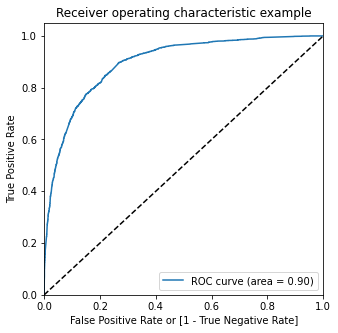




-----------------------------------------------------------------------------------------
                          Dataframe with different Cutoff Values 
-----------------------------------------------------------------------------------------

      Lead  Lead_Prob  predicted  Lead Score  0.0  0.1  0.2  0.3  0.4  0.5  \
1077   1.0   0.188470          0        19.0    1    1    0    0    0    0   
1576   0.0   0.631112          1        63.0    1    1    1    1    1    1   
3473   1.0   0.994028          1        99.0    1    1    1    1    1    1   
8673   1.0   0.213164          0        21.0    1    1    1    0    0    0   
12     1.0   0.859153          1        86.0    1    1    1    1    1    1   

      0.6  0.7  0.8  0.9  
1077    0    0    0    0  
1576    1    0    0    0  
3473    1    1    1    1  
8673    0    0    0    0  
12      1    1    1    0   

-----------------------------------------------------------------------------------------
                          C

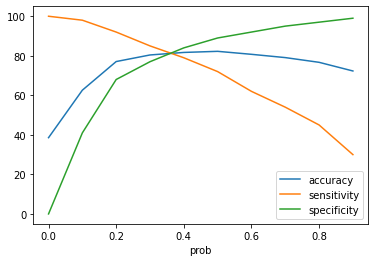



-----------------------------------------------------------------------------------------
Plot Recall/Precision
-----------------------------------------------------------------------------------------



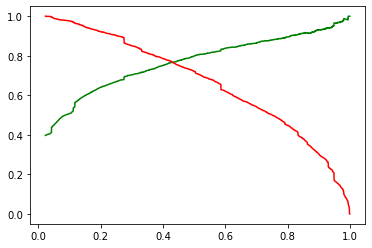

In [171]:
predict(X_train_oc,y_train,0.5,'N')

## Applying optimal cutoff value on training data set

In [172]:
predict(X_train_oc,y_train,0.36,'Y')

-----------------------------------------------------------------------------------------
                          Dataframe with the predicted values
-----------------------------------------------------------------------------------------

      Lead  Lead_Prob  predicted  Lead Score
1077   1.0   0.188470          0        19.0
1576   0.0   0.631112          1        63.0
3473   1.0   0.994028          1        99.0
8673   1.0   0.213164          0        21.0
12     1.0   0.859153          1        86.0 

-----------------------------------------------------------------------------------------
                          Confusion Matrix - For Cutoff 0.36
-----------------------------------------------------------------------------------------

[[3180  731]
 [ 471 1985]] 

* Accuracy Score - 81.12 
* Sensitivity - 81.0 
* Specificity - 81.0 
* False Positive - 19.0 
* Positive Predictive Value - 73.0 
* Negative Predictive Value - 87.0 
* F1 Score - 81.27 


##  Scale the Test data and evaluate the model 

In [173]:
df_test[col_num] = scaler.transform(df_test[col_num])
df_train.head()
y_test = df_test.pop('Converted')
X_test = df_test

In [174]:
X_train_oc.columns

Index(['const', 'Specialization_Not Sure', 'Last Activity_Email Opened',
       'Last Activity_Others', 'Last Activity_SMS Sent',
       'Last Notable Activity_Others', 'Last Notable Activity_SMS Sent',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Lead Source_Olark Chat', 'Lead Origin_Landing Page Submission',
       'Lead Origin_Lead Add Form', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit'],
      dtype='object')

In [175]:
X_test_lm_const = sm.add_constant(X_test[X_train_oc.columns[1:]])
X_test_lm_const.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2729 entries, 6409 to 2510
Data columns (total 16 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   const                                                 2729 non-null   float64
 1   Specialization_Not Sure                               2729 non-null   uint8  
 2   Last Activity_Email Opened                            2729 non-null   uint8  
 3   Last Activity_Others                                  2729 non-null   uint8  
 4   Last Activity_SMS Sent                                2729 non-null   uint8  
 5   Last Notable Activity_Others                          2729 non-null   uint8  
 6   Last Notable Activity_SMS Sent                        2729 non-null   uint8  
 7   What is your current occupation_Student               2729 non-null   uint8  
 8   What is your current occupation_Unemployed            2

In [176]:
y_test.unique()
predict(X_test_lm_const,y_test,0.36,'Y')

-----------------------------------------------------------------------------------------
                          Dataframe with the predicted values
-----------------------------------------------------------------------------------------

      Lead  Lead_Prob  predicted  Lead Score
6409   0.0   0.064512          0         6.0
2027   1.0   0.752023          1        75.0
9226   0.0   0.323992          0        32.0
7789   1.0   0.943239          1        94.0
5181   0.0   0.793777          1        79.0 

-----------------------------------------------------------------------------------------
                          Confusion Matrix - For Cutoff 0.36
-----------------------------------------------------------------------------------------

[[1388  332]
 [ 199  810]] 

* Accuracy Score - 80.54 
* Sensitivity - 80.0 
* Specificity - 81.0 
* False Positive - 19.0 
* Positive Predictive Value - 71.0 
* Negative Predictive Value - 87.0 
* F1 Score - 80.75 
